In [1]:
import pandas as pd
import numpy as np
import os
import sys
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List, Optional, Set, Union
import unicodedata

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to sys.path
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.entities.lineup import Lineup, Player, Position

from src.db.nst_db_utils import *
from src.db.nhl_db_utils import get_player_full_name, insert_player_data
from src.data_processing.nst_scraper import *
from src.data_processing.pbp_utils import *
from src.data_processing.game_utils import *
from src.data_processing.team_utils import *
from src.data_processing.player_utils import *

In [2]:
goalie_stats = get_goalie_stats(
    start_date="2024-10-01",
    end_date="2025-01-31",
    table_name="goalie_stats_5v5"
)

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.


In [3]:
goalie_stats

,date,player,team,toi,shots_against,saves,goals_against,sv_pct,gaa,gsaa,xg_against,hd_shots_against,hd_saves,hd_goals_against,hdsv_pct,md_shots_against,md_saves,md_goals_against,mdsv_pct,ld_shots_against,ld_saves,ld_goals_against,ldsv_pct,rush_attempts_against,rebound_attempts_against,avg_shot_distance,avg_goal_distance
0,2025-01-31,Daniil Tarasov,CBJ,50.23,24,23,1,0.958,1.19,1.52,2.66,5,4,1,0.8,3,3,0,1.0,16,16,0,1.0,1,8,37.92,10.0
1,2025-01-31,Thatcher Demko,VAN,46.75,12,10,2,0.833,2.57,-0.74,1.54,5,3,2,0.6,2,2,0,1.0,5,5,0,1.0,3,3,31.0,11.0
2,2025-01-31,Mackenzie Blackwood,COL,49.57,16,16,0,1.0,0.0,1.68,1.35,3,3,0,1.0,6,6,0,1.0,7,7,0,1.0,4,2,31.81,NaN
3,2025-01-31,Karel Vejmelka,UTA,50.23,16,14,2,0.875,2.39,-0.32,0.96,2,1,1,0.5,2,2,0,1.0,11,10,1,0.909,0,2,42.13,21.0
4,2025-01-31,Jake Oettinger,DAL,46.75,17,15,2,0.882,2.57,-0.22,1.39,4,3,1,0.75,0,0,0,NaN,11,10,1,0.909,1,2,51.24,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,2024-10-08,Petr Mrazek,CHI,50.7,24,20,4,0.833,4.73,-1.15,2.57,9,7,2,0.778,8,7,1,0.875,6,5,1,0.833,1,6,33.29,26.25
1726,2024-10-05,Devon Levi,BUF,45.43,26,24,2,0.923,2.64,-0.14,2.54,6,4,2,0.667,7,7,0,1.0,12,12,0,1.0,3,6,31.0,11.0
1727,2024-10-05,Jake Allen,NJD,45.43,16,15,1,0.938,1.32,0.14,1.39,3,2,1,0.667,1,1,0,1.0,11,11,0,1.0,1,4,46.19,7.0
1728,2024-10-04,Jacob Markstrom,NJD,46.72,26,25,1,0.962,1.28,1.31,2.59,5,4,1,0.8,5,5,0,1.0,15,15,0,1.0,3,7,41.46,16.0


In [4]:
db_prefix = 'NHL_DB_'

def extract_team_goalies(team: str, reference_date: Optional[str] = None) -> Lineup:
    """
    Gets stats for goalies in the lineup, maintaining lineup order.
    
    Args:
        team (str): The three-letter team code (e.g., 'TOR').
        reference_date (Optional[str]): The reference date in 'YYYY-MM-DD' format. Defaults to yesterday's date.
    
    Returns:
        Lineup: A `Lineup` object containing the team's players from the most recent game.
    
    Raises:
        ValueError: If no recent game is found for the team or if the team is not part of the retrieved game.
    """
    # Step 1: Determine the reference date
    if reference_date is None:
        today_datetime = datetime.now()
        yesterday_datetime = today_datetime - timedelta(days=1, hours=6)  # Adjust for UTC offset if necessary
        reference_date = yesterday_datetime.strftime('%Y-%m-%d')

    # Step 2: Retrieve the most recent game ID for the team
    game_id, back_to_back = get_most_recent_game_id(team, reference_date)
    if game_id is None:
        raise ValueError(f"No recent game found for team '{team}' before {reference_date}.")

    # Print the game_id
    print(f"Game ID: {game_id}")

    # Step 3: Fetch the game boxscore data
    game_data = get_game_boxscore(game_id, clean=False)

    # Step 4: Process the boxscore to obtain skaters and goalies
    away_skaters, away_goalies, home_skaters, home_goalies = display_boxscore(game_data)

    # Extract team abbreviations to determine if the team is home or away
    away_team_code = game_data.get('awayTeam', {}).get('abbrev')
    home_team_code = game_data.get('homeTeam', {}).get('abbrev')

    if not away_team_code or not home_team_code:
        raise ValueError("Team abbreviations not found in game data.")

    if team.upper() == away_team_code.upper():
        team_side = 'Away'
        skaters = away_skaters
        goalies = away_goalies
    elif team.upper() == home_team_code.upper():
        team_side = 'Home'
        skaters = home_skaters
        goalies = home_goalies
    elif team.upper() == 'UTA':
        # Since UTA did not exist in the previous season, match with ARI
        if 'ARI' == away_team_code.upper():
            team_side = 'Away'
            skaters = away_skaters
            goalies = away_goalies
        elif 'ARI' == home_team_code.upper():
            team_side = 'Home'
            skaters = home_skaters
            goalies = home_goalies
        else:
            raise ValueError(f"Team '{team}' not found in game ID {game_id}.")
    else:
        raise ValueError(f"Team '{team}' not found in game ID {game_id}.")

    # Step 5: Construct the Lineup object
    lineup = Lineup(name=f"{team.upper()} Lineup from Game {game_id}")
    print(f"Back to back: {back_to_back}")
    lineup.back_to_back = back_to_back  # Assign back_to_back to the Lineup

    # Add Goalies to the Lineup
    for _, goalie in goalies.iterrows():
        player = Player(
            player_id=goalie['playerId'],
            name=get_player_full_name(goalie['playerId'], db_prefix, suppress_log=True),
            team=team.upper(),
            position=Position.G
        )
        try:
            empty_slot = next(i for i, p in enumerate(lineup.goalies) if p is None)
            lineup.set_goalie(player, empty_slot)
        except StopIteration:
            print(f"No available goalie slot to add player '{player.name}'.")

    return lineup
# col_lineup = extract_team_lineup('COL', '2024-12-10')

In [5]:
def get_pregame_matchup_stats(input_date: str, team: str, last_n: int=None, team_stats_df: pd.DataFrame=None) -> Dict[str, Any]:
    """
    Retrieves and compiles pre-game statistics for both teams in a matchup.
    
    This function performs the following steps:
    1. Calculates reference date and retrieves team statistics
    2. Identifies the matchup game and opponent team
    3. Compiles team-level statistics for both teams
    4. Identifies starting goalies for both teams
    
    Args:
        input_date (str): The game date in 'YYYY-MM-DD' format
        team (str): The three-letter team code (e.g., 'TOR')
        last_n (int, optional): Number of previous games to consider for team statistics
        team_stats_df (pd.DataFrame, optional): Pre-loaded team statistics DataFrame. If None, will fetch new data
    
    Returns:
        pd.DataFrame: A DataFrame with two rows (one per team) containing:
            - Game context (date, game_id, home/away)
            - Team statistics
            - Starting goalie information (name, team, id)
    """
    try:
        # Step 1a: Calculate the date minus one day
        reference_datetime = datetime.strptime(input_date, '%Y-%m-%d') - timedelta(days=1)
        reference_date_str = reference_datetime.strftime('%Y-%m-%d')
        print(f"Fetching data for reference date: {reference_date_str}")

        # Step 1b: If team_stats_df is not provided, fetch them
        if team_stats_df is None or team_stats_df.empty:
            team_stats_df = nst_team_on_ice_scraper(
                startdate='',
                enddate=reference_date_str,
                stype=2,
                sit='all',
                last_n=last_n
            )

        # Step 3: Retrieve matchup games for the input date
        print(f"Retrieving matchup games for date {input_date}.")
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        game_dates = temp_data.get('game_ids', {}).get('date', [])

        # Initialize variables
        game_id = None
        opponent_team_tricode = None
        side = None

         # Step 4: Identify the game_id involving the specified team
        for gid, gdate in zip(game_ids, game_dates):
            print(f"Checking Game ID: {gid} on Date: {gdate}")
            boxscore = get_game_boxscore(gid, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            print(f"Away Team: {away_team}, Home Team: {home_team}")
            
            if team.upper() == away_team.upper():
                opponent_team_tricode = home_team.upper()
                game_id = gid
                side = 'A'
                print(f"Team {team} found as Away Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break
            elif team.upper() == home_team.upper():
                opponent_team_tricode = away_team.upper()
                game_id = gid
                side = 'H'
                print(f"Team {team} found as Home Team in Game ID {gid}. Opponent TriCode: {opponent_team_tricode}")
                # Check back-to-back status for both teams
                _, team_b2b = get_most_recent_game_id(team, input_date)
                _, opponent_b2b = get_most_recent_game_id(opponent_team_tricode, input_date)
                break

        if not game_id or not opponent_team_tricode:
            raise ValueError(f"Team {team} did not play on {input_date} or could not determine opponent.")
        
        # Step 5: Get full names for both teams
        team_fullname = get_fullname_by_tricode(team)
        opponent_team_fullname = get_fullname_by_tricode(opponent_team_tricode)

        if team_fullname is None or opponent_team_fullname is None:
            raise ValueError(f"Could not find full names for teams: {team} or {opponent_team_tricode}")
        
        # Remove accent marks and punctuation from both team names
        team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        opponent_team_fullname = ''.join(
            c for c in unicodedata.normalize('NFD', opponent_team_fullname)
            if unicodedata.category(c) != 'Mn' and (c.isalnum() or c.isspace())
        )
        
        # Create matchup DataFrame - Modified section
        if 'team' not in team_stats_df.columns:
            raise KeyError("Column 'team' not found in team_stats_df. Please verify the scraped data.")

        # Filter stats for both teams
        team_row = team_stats_df[team_stats_df['team'].str.lower() == team_fullname.lower()]
        opponent_row = team_stats_df[team_stats_df['team'].str.lower() == opponent_team_fullname.lower()]
        
        if team_row.empty or opponent_row.empty:
            raise ValueError(f"Could not find statistics for one or both teams")
            
        # Create a new DataFrame with team names but opponent stats
        matchup_df = pd.DataFrame()
        
        # First row: Keep team name but use opponent's stats
        first_row = opponent_row.copy()
        first_row['team'] = team
        
        # Second row: Keep opponent name but use team's stats
        second_row = team_row.copy()
        second_row['team'] = opponent_team_tricode
        
        # Combine rows
        matchup_df = pd.concat([first_row, second_row])
        
        # Add additional context columns
        matchup_df['home'] = [side == 'H', side == 'A']
        matchup_df['game_id'] = game_id
        matchup_df['game_date'] = input_date
        matchup_df['b2b'] = [team_b2b, opponent_b2b]  # First row has team's b2b, second row has opponent's b2b
        matchup_df['opp_b2b'] = [opponent_b2b, team_b2b]  # First row has opponent's b2b, second row has team's b2b

        # Convert team names to tricodes
        matchup_df['team'] = [team, opponent_team_tricode]

        # Drop specified columns
        columns_to_drop = ['gp', 'toi', 'w', 'l', 'otl', 'row', 'points', 'point_%']
        matchup_df = matchup_df.drop(columns=columns_to_drop, errors='ignore')

        # Reorder columns to put game_date and game_id first
        cols = matchup_df.columns.tolist()
        cols = ['game_date', 'game_id', 'home'] + [col for col in cols if col not in ['game_date', 'game_id', 'home']]
        matchup_df = matchup_df[cols]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
    
        # Get goalie information for both teams
        goalie_info = []
        for idx, row in matchup_df.iterrows():
            try:
                # If the game is in the past, just read the goalie from the boxscore
                if input_date < datetime.now().strftime('%Y-%m-%d'):
                    boxscore = get_game_boxscore(row['game_id'], clean=False)
                    # Use awayTeam for first row (idx=0), homeTeam for second row (idx=1)
                    team_type = 'awayTeam' if idx == 0 else 'homeTeam'
                    goalies = boxscore['playerByGameStats'][team_type]['goalies']
                    
                    if goalies:
                        # Sort goalies by TOI (descending) and take the one with most ice time
                        starting_goalie = max(goalies, key=lambda x: x.get('toi', '00:00'))
                        if starting_goalie.get('toi') != '00:00':
                            goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            if goalie_name is None:
                                player_data = fetch_player_data(starting_goalie.get('playerId'))
                                if player_data:
                                    insert_player_data(player_data, 'NHL_DB_')
                                goalie_name = get_player_full_name(starting_goalie.get('playerId'), 'NHL_DB_', suppress_log=True)
                            goalie_info.append({
                                'goalie_name': goalie_name,
                                'goalie_team': row['team'],
                                'goalie_id': starting_goalie.get('playerId')
                            })
                        else:
                            goalie_info.append({
                                'goalie_name': None,
                                'goalie_team': None,
                                'goalie_id': None
                            })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
                else:
                    lineup = extract_team_goalies(row['team'], input_date)
                    if lineup.goalies[0] is not None:  # Get starting goalie
                        goalie = lineup.goalies[0]
                        goalie_info.append({
                            'goalie_name': goalie.name,
                            'goalie_team': goalie.team,
                            'goalie_id': goalie.player_id
                        })
                    else:
                        goalie_info.append({
                            'goalie_name': None,
                            'goalie_team': None,
                            'goalie_id': None
                        })
            except Exception as e:
                print(f"Error getting goalie for {row['team']}: {e}")
                goalie_info.append({
                    'goalie_name': None,
                    'goalie_team': None,
                    'goalie_id': None
                })
        
        # Add goalie information to matchup_df
        for col in ['goalie_name', 'goalie_team', 'goalie_id']:
            matchup_df[col] = [info[col] for info in goalie_info]
        
        # Reset index
        matchup_df = matchup_df.reset_index(drop=True)
        
        return matchup_df

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# # # Example usage of the process_team_and_opponent function
# input_date = '2025-02-08'
# team = 'CHI'  # Example team code
# matchup_data = get_pregame_matchup_stats(input_date, team, last_n=14)

In [6]:
def calculate_goalie_rolling_stats(df, player_name: str, window_size: int = 10, date: str = None):
    """Create rolling averages and statistics for a specific goalie
    
    Args:
        df (pd.DataFrame): Input dataframe with goalie statistics
        player_name (str): Name of the player to process
        window_size (int, optional): Size of rolling window for statistics. Defaults to 10.
        date (str, optional): If provided, filter out data on or after this date
        
    Returns:
        pd.DataFrame: Processed statistics for the specified player or league averages if player not found
    """
    # Make a copy and filter for specific player
    player_df = df[df['player'] == player_name].copy()
    
    # If no data found for player, use league averages
    if player_df.empty:
        print(f"No data found for player: {player_name}. Using league averages.")
        
        # Calculate league averages
        league_df = df.copy()
        league_df['date'] = pd.to_datetime(league_df['date'])
        
        if date:
            cutoff_date = pd.to_datetime(date)
            league_df = league_df[league_df['date'] < cutoff_date]
        
        # Convert numeric columns from object to float
        numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                       'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
        for col in numeric_cols:
            league_df[col] = pd.to_numeric(league_df[col], errors='coerce')
        
        # Calculate league averages for all relevant columns
        feature_columns = [
            'shots_against', 'sv_pct', 'gaa', 'gsaa',
            'xg_against', 
            'hd_shots_against', 'hdsv_pct',
            'md_shots_against', 'mdsv_pct',
            'ld_shots_against', 'ldsv_pct'
        ]
        
        # Create a single row DataFrame with league averages
        league_averages = pd.DataFrame([{
            f'{col}_rolling_avg': league_df[col].mean() for col in feature_columns
        }])
        
        # Add standard deviations
        for col in feature_columns:
            league_averages[f'{col}_rolling_std'] = league_df[col].std()
        
        # Add workload features (use median values)
        league_averages['days_rest'] = 3.0  # typical rest between games
        league_averages['games_last_7'] = 2.0  # typical games in 7 days
        
        return league_averages
    
    # If we have player data, proceed with normal calculations
    player_df['date'] = pd.to_datetime(player_df['date'])
    player_df = player_df.sort_values('date')
    
    # Convert numeric columns from object to float
    numeric_cols = ['sv_pct', 'gaa', 'gsaa', 'xg_against', 'hdsv_pct', 
                   'mdsv_pct', 'ldsv_pct', 'avg_shot_distance', 'avg_goal_distance']
    for col in numeric_cols:
        player_df[col] = pd.to_numeric(player_df[col], errors='coerce')
    
    feature_columns = [
        'shots_against', 'sv_pct', 'gaa', 'gsaa',
        'xg_against', 
        'hd_shots_against', 'hdsv_pct',
        'md_shots_against', 'mdsv_pct',
        'ld_shots_against', 'ldsv_pct'
    ]
    
    try:
        print(f"Processing player: {player_name}")
        print(f"Data shape: {player_df.shape}")
        
        # Calculate rolling statistics
        for col in feature_columns:
            player_df[f'{col}_rolling_avg'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).mean()
            player_df[f'{col}_rolling_std'] = player_df[col].rolling(
                window=window_size, min_periods=1
            ).std()
        
        # Add workload features
        player_df['days_rest'] = player_df['date'].diff().dt.days
        player_df['games_last_7'] = player_df.rolling('7D', on='date')['date'].count()
        
        print(f"Successfully processed {player_name}")
        
        # Filter out dates if date is provided
        if date:
            cutoff_date = pd.to_datetime(date)
            player_df = player_df[player_df['date'] < cutoff_date]
            if player_df.empty:
                print(f"No data found for {player_name} before {date}. Using league averages.")
                return calculate_goalie_rolling_stats(df, player_name, window_size)  # Recursive call without date
            player_df = player_df.tail(1).reset_index(drop=True)

        # Keep only date, rolling features, and workload features
        rolling_cols = [col for col in player_df.columns if 'rolling' in col]
        cols_to_keep = ['date', 'player', 'team'] + rolling_cols + ['days_rest', 'games_last_7']
        player_df = player_df[cols_to_keep]
            
        return player_df
        
    except Exception as e:
        print(f"Error processing player {player_name}: {str(e)}")
        print("Data types:", player_df.dtypes)
        raise

In [7]:
def enrich_matchup_with_goalie_stats(
    matchup_df: pd.DataFrame,
    goalie_stats_df: pd.DataFrame,
    window_size: int = 10
) -> pd.DataFrame:
    """
    Enriches matchup data with rolling goalie statistics.
    
    Args:
        matchup_df (pd.DataFrame): Output from get_pregame_matchup_stats
        goalie_stats_df (pd.DataFrame): Raw goalie statistics
        window_size (int): Window size for rolling calculations
        
    Returns:
        pd.DataFrame: Enhanced matchup data with goalie rolling statistics
    """
    # Create a copy to avoid modifying original
    enriched_df = matchup_df.copy()
    
    # Process each goalie in the matchup
    for idx, row in enriched_df.iterrows():
        if pd.isna(row['goalie_name']):
            continue
            
        try:
            # Calculate rolling stats for this goalie
            goalie_rolling_stats = calculate_goalie_rolling_stats(
                goalie_stats_df,
                player_name=row['goalie_name'],
                window_size=window_size,
                date=row['game_date']
            )
            
            if not goalie_rolling_stats.empty:
                # Add prefix to rolling columns to avoid confusion with team stats
                rolling_cols = [col for col in goalie_rolling_stats.columns 
                              if col not in ['date', 'player', 'team']]
                
                for col in rolling_cols:
                    enriched_df.at[idx, f'g_{col}'] = goalie_rolling_stats.iloc[0][col]
                    
        except Exception as e:
            print(f"Error processing goalie {row['goalie_name']}: {e}")
            # Continue with next goalie if one fails
            continue
    
    return enriched_df

# matchup_data = enrich_matchup_with_goalie_stats(matchup_data, goalie_stats)

In [8]:
def get_matchup_goalie_results(matchup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Retrieves actual game results for goalies from a matchup DataFrame.
    
    Args:
        matchup_df (pd.DataFrame): DataFrame containing matchup data with game_id column
        
    Returns:
        pd.DataFrame: Original matchup data with additional columns for actual game results
    """
    # Get the boxscore data
    game_id = matchup_df['game_id'].iloc[0]
    game_data = get_game_boxscore(game_id, clean=False)
    player_stats = game_data.get('playerByGameStats', {})
    
    # Create a copy of the input DataFrame
    enriched_df = matchup_df.copy()
    
    # Process each team's data
    for idx, row in enriched_df.iterrows():
        team_type = 'homeTeam' if row['home'] else 'awayTeam'
        goalies = player_stats.get(team_type, {}).get('goalies', [])
        
        if goalies:
            # Find the goalie whose name matches the one in enriched_df
            matching_goalie = None
            for g in goalies:
                goalie_name = get_player_full_name(g.get('playerId'), 'NHL_DB_', suppress_log=True)
                if goalie_name == row['goalie_name']:
                    matching_goalie = g
                    break
            
            # If no matching goalie found, use the first one (as before)
            goalie = matching_goalie or goalies[0]
            
            shots = goalie.get('shotsAgainst', 0)
            saves = goalie.get('saves', 0)
            
            enriched_df.loc[idx, 'res_saves'] = saves
            enriched_df.loc[idx, 'res_shots_against'] = shots
            enriched_df.loc[idx, 'res_save_pct'] = round(saves / shots if shots > 0 else 0.0, 3)
            enriched_df.loc[idx, 'res_goals_against'] = goalie.get('goalsAgainst', 0)
            enriched_df.loc[idx, 'res_decision'] = goalie.get('decision', 'N/A')
    
    return enriched_df

In [9]:
def process_matchups_for_date(input_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes all matchup games for a given date by getting matchup stats, 
    enriching with goalie stats, and getting actual game results.
    
    Args:
        input_date (str): The reference date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date with 
                     pre-game stats and actual results
    """
    try:
        # Step 1: Get matchup games for the date
        temp_data = get_matchup_games(input_date, input_date)
        game_ids = temp_data.get('game_ids', {}).get('id', [])
        
        if not game_ids:
            print(f"No games found for the date {input_date}.")
            return pd.DataFrame()

        # Step 2: Get goalie stats for enrichment
        goalie_stats = get_goalie_stats(
            end_date=input_date,
            table_name="goalie_stats_5v5"
        )

        # Get team stats for matchup date so they are not scraped each time
        team_stats_df = nst_team_on_ice_scraper(
            startdate='',
            enddate=input_date,
            stype=2,
            sit='all',
            last_n=last_n
        )

        results = []
        
        # Step 3: Process each game
        for game_id in game_ids:
            print(f"\nProcessing Game ID: {game_id}")
            
            # Get boxscore to determine teams
            boxscore = get_game_boxscore(game_id, clean=True)
            away_team = boxscore.get('away_team')
            home_team = boxscore.get('home_team')
            
            if not away_team or not home_team:
                print(f"Could not extract teams for Game ID: {game_id}. Skipping.")
                continue
                
            # Process away team
            try:
                matchup = get_pregame_matchup_stats(input_date, away_team, last_n=last_n, team_stats_df=team_stats_df)
                matchup = enrich_matchup_with_goalie_stats(matchup, goalie_stats)
                matchup = get_matchup_goalie_results(matchup)
                results.append(matchup)
            except Exception as e:
                print(f"Error processing away team {away_team}: {e}")

        # Combine all results
        if results:
            final_df = pd.concat(results, ignore_index=True)
            print("\nAll matchups processed successfully.")
            return final_df
        else:
            print("No matchups were successfully processed.")
            return pd.DataFrame()

    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

In [10]:
# matchups = process_matchups_for_date('2024-12-10', last_n=15)

In [11]:
def process_matchups_for_date_range(start_date: str, end_date: str, last_n: int = None) -> pd.DataFrame:
    """
    Processes matchup games for a range of dates by calling process_matchups_for_date for each date.
    
    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        last_n (int, optional): Number of last games to consider for stats
    
    Returns:
        pd.DataFrame: A DataFrame containing all matchups for the date range with 
                     pre-game stats and actual results
    """
    try:
        # Convert dates to datetime objects
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        
        # Generate list of dates
        dates = pd.date_range(start=start, end=end, freq='D')
        
        all_results = []
        
        # Process each date
        for date in dates:
            date_str = date.strftime('%Y-%m-%d')
            print(f"\nProcessing date: {date_str}")
            
            # Process matchups for this date
            daily_results = process_matchups_for_date(date_str, last_n=last_n)
            if not daily_results.empty:
                all_results.append(daily_results)

            time.sleep(random.randint(60, 90))
        
        # Combine all results
        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            print(f"\nProcessed {len(dates)} days of matchups successfully.")
            return final_df
        else:
            print("No matchups were successfully processed for the date range.")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        raise

# Example usage:
matchups_range = process_matchups_for_date_range('2023-01-01', '2023-01-31', last_n=15)


Processing date: 2023-01-01


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020590
Fetching data for reference date: 2022-12-31
Retrieving matchup games for date 2023-01-01.
Checking Game ID: 2022020590 on Date: 2023-01-01
Away Team: CAR, Home Team: NJD
Team CAR found as Away Team in Game ID 2022020590. Opponent TriCode: NJD
Processing player: Antti Raanta
Data shape: (51, 27)
Successfully processed Antti Raanta
Processing player: Mackenzie Blackwood
Data shape: (68, 27)
Successfully processed Mackenzie Blackwood

Processing Game ID: 2022020591
Fetching data for reference date: 2022-12-31
Retrieving matchup games for date 2023-01-01.
Checking Game ID: 2022020590 on Date: 2023-01-01
Away Team: CAR, Home Team: NJD
Checking Game ID: 2022020591 on Date: 2023-01-01
Away Team: NYR, Home Team: FLA
Team NYR found as Away Team in Game ID 2022020591. Opponent TriCode: FLA
Processing player: Jaroslav Halak
Data shape: (46, 27)
Successfully processed Jaroslav Halak
Processing player: Sergei Bobrovsky
Data shape: (105, 27)
Successfully processed Se

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020595
Fetching data for reference date: 2023-01-01
Retrieving matchup games for date 2023-01-02.
Checking Game ID: 2022020595 on Date: 2023-01-02
Away Team: PIT, Home Team: BOS
Team PIT found as Away Team in Game ID 2022020595. Opponent TriCode: BOS
Processing player: Casey DeSmith
Data shape: (57, 27)
Successfully processed Casey DeSmith
Processing player: Linus Ullmark
Data shape: (83, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2022020596
Fetching data for reference date: 2023-01-01
Retrieving matchup games for date 2023-01-02.
Checking Game ID: 2022020595 on Date: 2023-01-02
Away Team: PIT, Home Team: BOS
Checking Game ID: 2022020596 on Date: 2023-01-02
Away Team: VGK, Home Team: COL
Team VGK found as Away Team in Game ID 2022020596. Opponent TriCode: COL
Processing player: Logan Thompson
Data shape: (43, 27)
Successfully processed Logan Thompson
Processing player: Alexandar Georgiev
Data shape: (72, 27)
Successfully processed Alexandar G

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020598
Fetching data for reference date: 2023-01-02
Retrieving matchup games for date 2023-01-03.
Checking Game ID: 2022020598 on Date: 2023-01-03
Away Team: ARI, Home Team: FLA
Team ARI found as Away Team in Game ID 2022020598. Opponent TriCode: FLA
Processing player: Karel Vejmelka
Data shape: (74, 27)
Successfully processed Karel Vejmelka
Processing player: Spencer Knight
Data shape: (52, 27)
Successfully processed Spencer Knight

Processing Game ID: 2022020599
Fetching data for reference date: 2023-01-02
Retrieving matchup games for date 2023-01-03.
Checking Game ID: 2022020598 on Date: 2023-01-03
Away Team: ARI, Home Team: FLA
Checking Game ID: 2022020599 on Date: 2023-01-03
Away Team: BUF, Home Team: WSH
Team BUF found as Away Team in Game ID 2022020599. Opponent TriCode: WSH
Processing player: Ukko-Pekka Luukkonen
Data shape: (22, 27)
Successfully processed Ukko-Pekka Luukkonen
Processing player: Darcy Kuemper
Data shape: (105, 27)
Successfully processed

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020609
Fetching data for reference date: 2023-01-03
Retrieving matchup games for date 2023-01-04.
Checking Game ID: 2022020609 on Date: 2023-01-04
Away Team: NJD, Home Team: DET
Team NJD found as Away Team in Game ID 2022020609. Opponent TriCode: DET
Processing player: Vitek Vanecek
Data shape: (100, 27)
Successfully processed Vitek Vanecek
Processing player: Ville Husso
Data shape: (79, 27)
Successfully processed Ville Husso

Processing Game ID: 2022020610
Fetching data for reference date: 2023-01-03
Retrieving matchup games for date 2023-01-04.
Checking Game ID: 2022020609 on Date: 2023-01-04
Away Team: NJD, Home Team: DET
Checking Game ID: 2022020610 on Date: 2023-01-04
Away Team: TBL, Home Team: MIN
Team TBL found as Away Team in Game ID 2022020610. Opponent TriCode: MIN
Processing player: Brian Elliott
Data shape: (59, 27)
Successfully processed Brian Elliott
Processing player: Filip Gustavsson
Data shape: (40, 27)
Successfully processed Filip Gustavsson



INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020612
Fetching data for reference date: 2023-01-04
Retrieving matchup games for date 2023-01-05.
Checking Game ID: 2022020612 on Date: 2023-01-05
Away Team: ARI, Home Team: PHI
Team ARI found as Away Team in Game ID 2022020612. Opponent TriCode: PHI
Processing player: Karel Vejmelka
Data shape: (75, 27)
Successfully processed Karel Vejmelka
Processing player: Carter Hart
Data shape: (97, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020613
Fetching data for reference date: 2023-01-04
Retrieving matchup games for date 2023-01-05.
Checking Game ID: 2022020612 on Date: 2023-01-05
Away Team: ARI, Home Team: PHI
Checking Game ID: 2022020613 on Date: 2023-01-05
Away Team: NYR, Home Team: MTL
Team NYR found as Away Team in Game ID 2022020613. Opponent TriCode: MTL
Processing player: Jaroslav Halak
Data shape: (47, 27)
Successfully processed Jaroslav Halak
Processing player: Jake Allen
Data shape: (86, 27)
Successfully processed Jake Allen

Processin

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020622
Fetching data for reference date: 2023-01-05
Retrieving matchup games for date 2023-01-06.
Checking Game ID: 2022020622 on Date: 2023-01-06
Away Team: NSH, Home Team: WSH
Team NSH found as Away Team in Game ID 2022020622. Opponent TriCode: WSH
Processing player: Kevin Lankinen
Data shape: (78, 27)
Successfully processed Kevin Lankinen
Processing player: Charlie Lindgren
Data shape: (21, 27)
Successfully processed Charlie Lindgren

Processing Game ID: 2022020623
Fetching data for reference date: 2023-01-05
Retrieving matchup games for date 2023-01-06.
Checking Game ID: 2022020622 on Date: 2023-01-06
Away Team: NSH, Home Team: WSH
Checking Game ID: 2022020623 on Date: 2023-01-06
Away Team: FLA, Home Team: DET
Team FLA found as Away Team in Game ID 2022020623. Opponent TriCode: DET
Processing player: Sergei Bobrovsky
Data shape: (106, 27)
Successfully processed Sergei Bobrovsky
Processing player: Ville Husso
Data shape: (80, 27)
Successfully processed Ville

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020628
Fetching data for reference date: 2023-01-06
Retrieving matchup games for date 2023-01-07.
Checking Game ID: 2022020628 on Date: 2023-01-07
Away Team: NYR, Home Team: NJD
Team NYR found as Away Team in Game ID 2022020628. Opponent TriCode: NJD
Processing player: Igor Shesterkin
Data shape: (114, 27)
Successfully processed Igor Shesterkin
Processing player: Vitek Vanecek
Data shape: (101, 27)
Successfully processed Vitek Vanecek

Processing Game ID: 2022020629
Fetching data for reference date: 2023-01-06
Retrieving matchup games for date 2023-01-07.
Checking Game ID: 2022020628 on Date: 2023-01-07
Away Team: NYR, Home Team: NJD
Checking Game ID: 2022020629 on Date: 2023-01-07
Away Team: CAR, Home Team: CBJ
Team CAR found as Away Team in Game ID 2022020629. Opponent TriCode: CBJ
Processing player: Antti Raanta
Data shape: (52, 27)
Successfully processed Antti Raanta
Processing player: Joonas Korpisalo
Data shape: (69, 27)
Successfully processed Joonas Korp

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020638
Fetching data for reference date: 2023-01-07
Retrieving matchup games for date 2023-01-08.
Checking Game ID: 2022020638 on Date: 2023-01-08
Away Team: VAN, Home Team: WPG
Team VAN found as Away Team in Game ID 2022020638. Opponent TriCode: WPG
Processing player: Spencer Martin
Data shape: (24, 27)
Successfully processed Spencer Martin
Processing player: David Rittich
Data shape: (44, 27)
Successfully processed David Rittich

Processing Game ID: 2022020637
Fetching data for reference date: 2023-01-07
Retrieving matchup games for date 2023-01-08.
Checking Game ID: 2022020638 on Date: 2023-01-08
Away Team: VAN, Home Team: WPG
Checking Game ID: 2022020637 on Date: 2023-01-08
Away Team: FLA, Home Team: DAL
Team FLA found as Away Team in Game ID 2022020637. Opponent TriCode: DAL
Processing player: Spencer Knight
Data shape: (53, 27)
Successfully processed Spencer Knight
Processing player: Jake Oettinger
Data shape: (101, 27)
Successfully processed Jake Oetting

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020990
Fetching data for reference date: 2023-01-08
Retrieving matchup games for date 2023-01-09.
Checking Game ID: 2022020990 on Date: 2023-01-09
Away Team: PHI, Home Team: BUF
Team PHI found as Away Team in Game ID 2022020990. Opponent TriCode: BUF
Processing player: Samuel Ersson
Data shape: (2, 27)
Successfully processed Samuel Ersson
Processing player: Craig Anderson
Data shape: (50, 27)
Successfully processed Craig Anderson

Processing Game ID: 2022020645
Fetching data for reference date: 2023-01-08
Retrieving matchup games for date 2023-01-09.
Checking Game ID: 2022020990 on Date: 2023-01-09
Away Team: PHI, Home Team: BUF
Checking Game ID: 2022020645 on Date: 2023-01-09
Away Team: NSH, Home Team: OTT
Team NSH found as Away Team in Game ID 2022020645. Opponent TriCode: OTT
Processing player: Juuse Saros
Data shape: (128, 27)
Successfully processed Juuse Saros
Processing player: Cam Talbot
Data shape: (101, 27)
Successfully processed Cam Talbot

Processing

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020648
Fetching data for reference date: 2023-01-09
Retrieving matchup games for date 2023-01-10.
Checking Game ID: 2022020648 on Date: 2023-01-10
Away Team: CBJ, Home Team: TBL
Team CBJ found as Away Team in Game ID 2022020648. Opponent TriCode: TBL
Processing player: Elvis Merzlikins
Data shape: (104, 27)
Successfully processed Elvis Merzlikins
Processing player: Andrei Vasilevskiy
Data shape: (129, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020649
Fetching data for reference date: 2023-01-09
Retrieving matchup games for date 2023-01-10.
Checking Game ID: 2022020648 on Date: 2023-01-10
Away Team: CBJ, Home Team: TBL
Checking Game ID: 2022020649 on Date: 2023-01-10
Away Team: MIN, Home Team: NYR
Team MIN found as Away Team in Game ID 2022020649. Opponent TriCode: NYR
Processing player: Marc-Andre Fleury
Data shape: (115, 27)
Successfully processed Marc-Andre Fleury
Processing player: Igor Shesterkin
Data shape: (115, 27)
Successfull

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020659
Fetching data for reference date: 2023-01-10
Retrieving matchup games for date 2023-01-11.
Checking Game ID: 2022020659 on Date: 2023-01-11
Away Team: WSH, Home Team: PHI
Team WSH found as Away Team in Game ID 2022020659. Opponent TriCode: PHI
Processing player: Darcy Kuemper
Data shape: (108, 27)
Successfully processed Darcy Kuemper
Processing player: Carter Hart
Data shape: (99, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020658
Fetching data for reference date: 2023-01-10
Retrieving matchup games for date 2023-01-11.
Checking Game ID: 2022020659 on Date: 2023-01-11
Away Team: WSH, Home Team: PHI
Checking Game ID: 2022020658 on Date: 2023-01-11
Away Team: NSH, Home Team: TOR
Team NSH found as Away Team in Game ID 2022020658. Opponent TriCode: TOR
Processing player: Juuse Saros
Data shape: (129, 27)
Successfully processed Juuse Saros
Processing player: Matt Murray
Data shape: (61, 27)
Successfully processed Matt Murray

Processing Ga

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020662
Fetching data for reference date: 2023-01-11
Retrieving matchup games for date 2023-01-12.
Checking Game ID: 2022020662 on Date: 2023-01-12
Away Team: CAR, Home Team: CBJ
Team CAR found as Away Team in Game ID 2022020662. Opponent TriCode: CBJ
Processing player: Frederik Andersen
Data shape: (85, 27)
Successfully processed Frederik Andersen
Processing player: Joonas Korpisalo
Data shape: (70, 27)
Successfully processed Joonas Korpisalo

Processing Game ID: 2022020663
Fetching data for reference date: 2023-01-11
Retrieving matchup games for date 2023-01-12.
Checking Game ID: 2022020662 on Date: 2023-01-12
Away Team: CAR, Home Team: CBJ
Checking Game ID: 2022020663 on Date: 2023-01-12
Away Team: DAL, Home Team: NYR
Team DAL found as Away Team in Game ID 2022020663. Opponent TriCode: NYR
Processing player: Jake Oettinger
Data shape: (103, 27)
Successfully processed Jake Oettinger
Processing player: Igor Shesterkin
Data shape: (116, 27)
Successfully processe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020674
Fetching data for reference date: 2023-01-12
Retrieving matchup games for date 2023-01-13.
Checking Game ID: 2022020674 on Date: 2023-01-13
Away Team: WPG, Home Team: PIT
Team WPG found as Away Team in Game ID 2022020674. Opponent TriCode: PIT
Processing player: David Rittich
Data shape: (45, 27)
Successfully processed David Rittich
Processing player: Dustin Tokarski
Data shape: (44, 27)
Successfully processed Dustin Tokarski

Processing Game ID: 2022020675
Fetching data for reference date: 2023-01-12
Retrieving matchup games for date 2023-01-13.
Checking Game ID: 2022020674 on Date: 2023-01-13
Away Team: WPG, Home Team: PIT
Checking Game ID: 2022020675 on Date: 2023-01-13
Away Team: NJD, Home Team: ANA
Team NJD found as Away Team in Game ID 2022020675. Opponent TriCode: ANA
Processing player: Vitek Vanecek
Data shape: (103, 27)
Successfully processed Vitek Vanecek
Processing player: John Gibson
Data shape: (118, 27)
Successfully processed John Gibson

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020677
Fetching data for reference date: 2023-01-13
Retrieving matchup games for date 2023-01-14.
Checking Game ID: 2022020677 on Date: 2023-01-14
Away Team: CGY, Home Team: DAL
Team CGY found as Away Team in Game ID 2022020677. Opponent TriCode: DAL
Processing player: Dan Vladar
Data shape: (42, 27)
Successfully processed Dan Vladar
Processing player: Scott Wedgewood
Data shape: (68, 27)
Successfully processed Scott Wedgewood

Processing Game ID: 2022020678
Fetching data for reference date: 2023-01-13
Retrieving matchup games for date 2023-01-14.
Checking Game ID: 2022020677 on Date: 2023-01-14
Away Team: CGY, Home Team: DAL
Checking Game ID: 2022020678 on Date: 2023-01-14
Away Team: CBJ, Home Team: DET
Team CBJ found as Away Team in Game ID 2022020678. Opponent TriCode: DET
Processing player: Elvis Merzlikins
Data shape: (105, 27)
Successfully processed Elvis Merzlikins
Processing player: Ville Husso
Data shape: (83, 27)
Successfully processed Ville Husso

Pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020691
Fetching data for reference date: 2023-01-14
Retrieving matchup games for date 2023-01-15.
Checking Game ID: 2022020691 on Date: 2023-01-15
Away Team: MTL, Home Team: NYR
Team MTL found as Away Team in Game ID 2022020691. Opponent TriCode: NYR
Processing player: Sam Montembeault
Data shape: (53, 27)
Successfully processed Sam Montembeault
Processing player: Igor Shesterkin
Data shape: (117, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020692
Fetching data for reference date: 2023-01-14
Retrieving matchup games for date 2023-01-15.
Checking Game ID: 2022020691 on Date: 2023-01-15
Away Team: MTL, Home Team: NYR
Checking Game ID: 2022020692 on Date: 2023-01-15
Away Team: VAN, Home Team: CAR
Team VAN found as Away Team in Game ID 2022020692. Opponent TriCode: CAR
Processing player: Collin Delia
Data shape: (18, 27)
Successfully processed Collin Delia
Processing player: Pyotr Kochetkov
Data shape: (21, 27)
Successfully processed Pyotr K

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020694
Fetching data for reference date: 2023-01-15
Retrieving matchup games for date 2023-01-16.
Checking Game ID: 2022020694 on Date: 2023-01-16
Away Team: FLA, Home Team: BUF
Team FLA found as Away Team in Game ID 2022020694. Opponent TriCode: BUF
Processing player: Sergei Bobrovsky
Data shape: (110, 27)
Successfully processed Sergei Bobrovsky
Processing player: Ukko-Pekka Luukkonen
Data shape: (26, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2022020695
Fetching data for reference date: 2023-01-15
Retrieving matchup games for date 2023-01-16.
Checking Game ID: 2022020694 on Date: 2023-01-16
Away Team: FLA, Home Team: BUF
Checking Game ID: 2022020695 on Date: 2023-01-16
Away Team: PHI, Home Team: BOS
Team PHI found as Away Team in Game ID 2022020695. Opponent TriCode: BOS
Processing player: Samuel Ersson
Data shape: (3, 27)
Successfully processed Samuel Ersson
Processing player: Jeremy Swayman
Data shape: (65, 27)
Successfully process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020705
Fetching data for reference date: 2023-01-16
Retrieving matchup games for date 2023-01-17.
Checking Game ID: 2022020705 on Date: 2023-01-17
Away Team: ANA, Home Team: PHI
Team ANA found as Away Team in Game ID 2022020705. Opponent TriCode: PHI
Processing player: Anthony Stolarz
Data shape: (52, 27)
Successfully processed Anthony Stolarz
Processing player: Samuel Ersson
Data shape: (4, 27)
Successfully processed Samuel Ersson

Processing Game ID: 2022020706
Fetching data for reference date: 2023-01-16
Retrieving matchup games for date 2023-01-17.
Checking Game ID: 2022020705 on Date: 2023-01-17
Away Team: ANA, Home Team: PHI
Checking Game ID: 2022020706 on Date: 2023-01-17
Away Team: FLA, Home Team: TOR
Team FLA found as Away Team in Game ID 2022020706. Opponent TriCode: TOR
Processing player: Sergei Bobrovsky
Data shape: (111, 27)
Successfully processed Sergei Bobrovsky
Processing player: Ilya Samsonov
Data shape: (78, 27)
Successfully processed Ilya Sam

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020712
Fetching data for reference date: 2023-01-17
Retrieving matchup games for date 2023-01-18.
Checking Game ID: 2022020712 on Date: 2023-01-18
Away Team: PIT, Home Team: OTT
Team PIT found as Away Team in Game ID 2022020712. Opponent TriCode: OTT
Processing player: Casey DeSmith
Data shape: (63, 27)
Successfully processed Casey DeSmith
Processing player: Cam Talbot
Data shape: (103, 27)
Successfully processed Cam Talbot

Processing Game ID: 2022020713
Fetching data for reference date: 2023-01-17
Retrieving matchup games for date 2023-01-18.
Checking Game ID: 2022020712 on Date: 2023-01-18
Away Team: PIT, Home Team: OTT
Checking Game ID: 2022020713 on Date: 2023-01-18
Away Team: BOS, Home Team: NYI
Team BOS found as Away Team in Game ID 2022020713. Opponent TriCode: NYI
Processing player: Linus Ullmark
Data shape: (87, 27)
Successfully processed Linus Ullmark
Processing player: Semyon Varlamov
Data shape: (81, 27)
Successfully processed Semyon Varlamov

Proc

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020717
Fetching data for reference date: 2023-01-18
Retrieving matchup games for date 2023-01-19.
Checking Game ID: 2022020717 on Date: 2023-01-19
Away Team: ANA, Home Team: CBJ
Team ANA found as Away Team in Game ID 2022020717. Opponent TriCode: CBJ
Processing player: John Gibson
Data shape: (120, 27)
Successfully processed John Gibson
Processing player: Elvis Merzlikins
Data shape: (107, 27)
Successfully processed Elvis Merzlikins

Processing Game ID: 2022020718
Fetching data for reference date: 2023-01-18
Retrieving matchup games for date 2023-01-19.
Checking Game ID: 2022020717 on Date: 2023-01-19
Away Team: ANA, Home Team: CBJ
Checking Game ID: 2022020718 on Date: 2023-01-19
Away Team: BOS, Home Team: NYR
Team BOS found as Away Team in Game ID 2022020718. Opponent TriCode: NYR
Processing player: Jeremy Swayman
Data shape: (66, 27)
Successfully processed Jeremy Swayman
Processing player: Igor Shesterkin
Data shape: (118, 27)
Successfully processed Igor Shes

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020730
Fetching data for reference date: 2023-01-19
Retrieving matchup games for date 2023-01-20.
Checking Game ID: 2022020730 on Date: 2023-01-20
Away Team: OTT, Home Team: PIT
Team OTT found as Away Team in Game ID 2022020730. Opponent TriCode: PIT
Processing player: Cam Talbot
Data shape: (104, 27)
Successfully processed Cam Talbot
Processing player: Tristan Jarry
Data shape: (119, 27)
Successfully processed Tristan Jarry

Processing Game ID: 2022020731
Fetching data for reference date: 2023-01-19
Retrieving matchup games for date 2023-01-20.
Checking Game ID: 2022020730 on Date: 2023-01-20
Away Team: OTT, Home Team: PIT
Checking Game ID: 2022020731 on Date: 2023-01-20
Away Team: COL, Home Team: VAN
Team COL found as Away Team in Game ID 2022020731. Opponent TriCode: VAN
Processing player: Alexandar Georgiev
Data shape: (77, 27)
Successfully processed Alexandar Georgiev
Processing player: Collin Delia
Data shape: (20, 27)
Successfully processed Collin Delia


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020732
Fetching data for reference date: 2023-01-20
Retrieving matchup games for date 2023-01-21.
Checking Game ID: 2022020732 on Date: 2023-01-21
Away Team: ANA, Home Team: BUF
Team ANA found as Away Team in Game ID 2022020732. Opponent TriCode: BUF
Processing player: John Gibson
Data shape: (121, 27)
Successfully processed John Gibson
Processing player: Ukko-Pekka Luukkonen
Data shape: (28, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2022020733
Fetching data for reference date: 2023-01-20
Retrieving matchup games for date 2023-01-21.
Checking Game ID: 2022020732 on Date: 2023-01-21
Away Team: ANA, Home Team: BUF
Checking Game ID: 2022020733 on Date: 2023-01-21
Away Team: TBL, Home Team: CGY
Team TBL found as Away Team in Game ID 2022020733. Opponent TriCode: CGY
Processing player: Andrei Vasilevskiy
Data shape: (134, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Dan Vladar
Data shape: (43, 27)
Successfully processed

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020746
Fetching data for reference date: 2023-01-21
Retrieving matchup games for date 2023-01-22.
Checking Game ID: 2022020746 on Date: 2023-01-22
Away Team: PIT, Home Team: NJD
Team PIT found as Away Team in Game ID 2022020746. Opponent TriCode: NJD
Processing player: Tristan Jarry
Data shape: (120, 27)
Successfully processed Tristan Jarry
Processing player: Vitek Vanecek
Data shape: (105, 27)
Successfully processed Vitek Vanecek

Processing Game ID: 2022020747
Fetching data for reference date: 2023-01-21
Retrieving matchup games for date 2023-01-22.
Checking Game ID: 2022020746 on Date: 2023-01-22
Away Team: PIT, Home Team: NJD
Checking Game ID: 2022020747 on Date: 2023-01-22
Away Team: LAK, Home Team: CHI
Team LAK found as Away Team in Game ID 2022020747. Opponent TriCode: CHI
Processing player: Pheonix Copley
Data shape: (15, 27)
Successfully processed Pheonix Copley
Processing player: Petr Mrazek
Data shape: (49, 27)
Successfully processed Petr Mrazek

Pro

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020751
Fetching data for reference date: 2023-01-22
Retrieving matchup games for date 2023-01-23.
Checking Game ID: 2022020751 on Date: 2023-01-23
Away Team: FLA, Home Team: NYR
Team FLA found as Away Team in Game ID 2022020751. Opponent TriCode: NYR
Processing player: Alex Lyon
Data shape: (11, 27)
Successfully processed Alex Lyon
Processing player: Igor Shesterkin
Data shape: (119, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020752
Fetching data for reference date: 2023-01-22
Retrieving matchup games for date 2023-01-23.
Checking Game ID: 2022020751 on Date: 2023-01-23
Away Team: FLA, Home Team: NYR
Checking Game ID: 2022020752 on Date: 2023-01-23
Away Team: NYI, Home Team: TOR
Team NYI found as Away Team in Game ID 2022020752. Opponent TriCode: TOR
Processing player: Ilya Sorokin
Data shape: (106, 27)
Successfully processed Ilya Sorokin
Processing player: Ilya Samsonov
Data shape: (81, 27)
Successfully processed Ilya Samsonov

Process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020755
Fetching data for reference date: 2023-01-23
Retrieving matchup games for date 2023-01-24.
Checking Game ID: 2022020755 on Date: 2023-01-24
Away Team: BOS, Home Team: MTL
Team BOS found as Away Team in Game ID 2022020755. Opponent TriCode: MTL
Processing player: Jeremy Swayman
Data shape: (68, 27)
Successfully processed Jeremy Swayman
Processing player: Sam Montembeault
Data shape: (57, 27)
Successfully processed Sam Montembeault

Processing Game ID: 2022020756
Fetching data for reference date: 2023-01-23
Retrieving matchup games for date 2023-01-24.
Checking Game ID: 2022020755 on Date: 2023-01-24
Away Team: BOS, Home Team: MTL
Checking Game ID: 2022020756 on Date: 2023-01-24
Away Team: FLA, Home Team: PIT
Team FLA found as Away Team in Game ID 2022020756. Opponent TriCode: PIT
Processing player: Alex Lyon
Data shape: (12, 27)
Successfully processed Alex Lyon
Processing player: Casey DeSmith
Data shape: (64, 27)
Successfully processed Casey DeSmith

Pro

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020766
Fetching data for reference date: 2023-01-24
Retrieving matchup games for date 2023-01-25.
Checking Game ID: 2022020766 on Date: 2023-01-25
Away Team: NYI, Home Team: OTT
Team NYI found as Away Team in Game ID 2022020766. Opponent TriCode: OTT
Processing player: Semyon Varlamov
Data shape: (82, 27)
Successfully processed Semyon Varlamov
Processing player: Anton Forsberg
Data shape: (78, 27)
Successfully processed Anton Forsberg

Processing Game ID: 2022020767
Fetching data for reference date: 2023-01-24
Retrieving matchup games for date 2023-01-25.
Checking Game ID: 2022020766 on Date: 2023-01-25
Away Team: NYI, Home Team: OTT
Checking Game ID: 2022020767 on Date: 2023-01-25
Away Team: NYR, Home Team: TOR
Team NYR found as Away Team in Game ID 2022020767. Opponent TriCode: TOR
Processing player: Igor Shesterkin
Data shape: (120, 27)
Successfully processed Igor Shesterkin
Processing player: Ilya Samsonov
Data shape: (82, 27)
Successfully processed Ilya Sa

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020771
Fetching data for reference date: 2023-01-25
Retrieving matchup games for date 2023-01-26.
Checking Game ID: 2022020771 on Date: 2023-01-26
Away Team: BOS, Home Team: TBL
Team BOS found as Away Team in Game ID 2022020771. Opponent TriCode: TBL
Processing player: Linus Ullmark
Data shape: (89, 27)
Successfully processed Linus Ullmark
Processing player: Andrei Vasilevskiy
Data shape: (136, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020772
Fetching data for reference date: 2023-01-25
Retrieving matchup games for date 2023-01-26.
Checking Game ID: 2022020771 on Date: 2023-01-26
Away Team: BOS, Home Team: TBL
Checking Game ID: 2022020772 on Date: 2023-01-26
Away Team: DET, Home Team: MTL
Team DET found as Away Team in Game ID 2022020772. Opponent TriCode: MTL
Processing player: Ville Husso
Data shape: (88, 27)
Successfully processed Ville Husso
Processing player: Jake Allen
Data shape: (88, 27)
Successfully processed Jake Allen

Pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020780
Fetching data for reference date: 2023-01-26
Retrieving matchup games for date 2023-01-27.
Checking Game ID: 2022020780 on Date: 2023-01-27
Away Team: DET, Home Team: NYI
Team DET found as Away Team in Game ID 2022020780. Opponent TriCode: NYI
Processing player: Magnus Hellberg
Data shape: (7, 27)
Successfully processed Magnus Hellberg
Processing player: Ilya Sorokin
Data shape: (107, 27)
Successfully processed Ilya Sorokin

Processing Game ID: 2022020781
Fetching data for reference date: 2023-01-26
Retrieving matchup games for date 2023-01-27.
Checking Game ID: 2022020780 on Date: 2023-01-27
Away Team: DET, Home Team: NYI
Checking Game ID: 2022020781 on Date: 2023-01-27
Away Team: LAK, Home Team: FLA
Team LAK found as Away Team in Game ID 2022020781. Opponent TriCode: FLA
Processing player: Pheonix Copley
Data shape: (17, 27)
Successfully processed Pheonix Copley
Processing player: Alex Lyon
Data shape: (13, 27)
Successfully processed Alex Lyon

Process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020788
Fetching data for reference date: 2023-01-27
Retrieving matchup games for date 2023-01-28.
Checking Game ID: 2022020788 on Date: 2023-01-28
Away Team: STL, Home Team: COL
Team STL found as Away Team in Game ID 2022020788. Opponent TriCode: COL
Processing player: Jordan Binnington
Data shape: (112, 27)
Successfully processed Jordan Binnington
Processing player: Alexandar Georgiev
Data shape: (79, 27)
Successfully processed Alexandar Georgiev

Processing Game ID: 2022020789
Fetching data for reference date: 2023-01-27
Retrieving matchup games for date 2023-01-28.
Checking Game ID: 2022020788 on Date: 2023-01-28
Away Team: STL, Home Team: COL
Checking Game ID: 2022020789 on Date: 2023-01-28
Away Team: BOS, Home Team: FLA
Team BOS found as Away Team in Game ID 2022020789. Opponent TriCode: FLA
Processing player: Jeremy Swayman
Data shape: (69, 27)
Successfully processed Jeremy Swayman
Processing player: Alex Lyon
Data shape: (14, 27)
Successfully processed A

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020799
Fetching data for reference date: 2023-01-28
Retrieving matchup games for date 2023-01-29.
Checking Game ID: 2022020799 on Date: 2023-01-29
Away Team: BOS, Home Team: CAR
Team BOS found as Away Team in Game ID 2022020799. Opponent TriCode: CAR
Processing player: Linus Ullmark
Data shape: (90, 27)
Successfully processed Linus Ullmark
Processing player: Frederik Andersen
Data shape: (90, 27)
Successfully processed Frederik Andersen

Processing Game ID: 2022020800
Fetching data for reference date: 2023-01-28
Retrieving matchup games for date 2023-01-29.
Checking Game ID: 2022020799 on Date: 2023-01-29
Away Team: BOS, Home Team: CAR
Checking Game ID: 2022020800 on Date: 2023-01-29
Away Team: WSH, Home Team: TOR
Team WSH found as Away Team in Game ID 2022020800. Opponent TriCode: TOR
Processing player: Darcy Kuemper
Data shape: (115, 27)
Successfully processed Darcy Kuemper
Processing player: Ilya Samsonov
Data shape: (84, 27)
Successfully processed Ilya Sams

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020801
Fetching data for reference date: 2023-01-29
Retrieving matchup games for date 2023-01-30.
Checking Game ID: 2022020801 on Date: 2023-01-30
Away Team: STL, Home Team: WPG
Team STL found as Away Team in Game ID 2022020801. Opponent TriCode: WPG
Processing player: Jordan Binnington
Data shape: (113, 27)
Successfully processed Jordan Binnington
Processing player: Connor Hellebuyck
Data shape: (147, 27)
Successfully processed Connor Hellebuyck

All matchups processed successfully.

Processing date: 2023-01-31


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020802
Fetching data for reference date: 2023-01-30
Retrieving matchup games for date 2023-01-31.
Checking Game ID: 2022020802 on Date: 2023-01-31
Away Team: LAK, Home Team: CAR
Team LAK found as Away Team in Game ID 2022020802. Opponent TriCode: CAR
Processing player: Pheonix Copley
Data shape: (18, 27)
Successfully processed Pheonix Copley
Processing player: Frederik Andersen
Data shape: (91, 27)
Successfully processed Frederik Andersen

Processing Game ID: 2022020803
Fetching data for reference date: 2023-01-30
Retrieving matchup games for date 2023-01-31.
Checking Game ID: 2022020802 on Date: 2023-01-31
Away Team: LAK, Home Team: CAR
Checking Game ID: 2022020803 on Date: 2023-01-31
Away Team: OTT, Home Team: MTL
Team OTT found as Away Team in Game ID 2022020803. Opponent TriCode: MTL
Processing player: Anton Forsberg
Data shape: (81, 27)
Successfully processed Anton Forsberg
Processing player: Jake Allen
Data shape: (89, 27)
Successfully processed Jake Alle

In [12]:
matchups_range.to_csv('../data/g_15_01_23.csv', index=False)

In [13]:
matchups_range2 = process_matchups_for_date_range('2022-12-01', '2022-12-31', last_n=15)
matchups_range2.to_csv('../data/g_15_12_22.csv', index=False)
matchups_range3 = process_matchups_for_date_range('2022-11-01', '2022-11-30', last_n=15)
matchups_range3.to_csv('../data/g_15_11_22.csv', index=False)
matchups_range4 = process_matchups_for_date_range('2022-10-07', '2022-10-31', last_n=15)
matchups_range4.to_csv('../data/g_15_10_22.csv', index=False)


Processing date: 2022-12-01


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020365
Fetching data for reference date: 2022-11-30
Retrieving matchup games for date 2022-12-01.
Checking Game ID: 2022020365 on Date: 2022-12-01
Away Team: COL, Home Team: BUF
Team COL found as Away Team in Game ID 2022020365. Opponent TriCode: BUF
Processing player: Alexandar Georgiev
Data shape: (66, 27)
Successfully processed Alexandar Georgiev
Processing player: Ukko-Pekka Luukkonen
Data shape: (17, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2022020366
Fetching data for reference date: 2022-11-30
Retrieving matchup games for date 2022-12-01.
Checking Game ID: 2022020365 on Date: 2022-12-01
Away Team: COL, Home Team: BUF
Checking Game ID: 2022020366 on Date: 2022-12-01
Away Team: NSH, Home Team: NJD
Team NSH found as Away Team in Game ID 2022020366. Opponent TriCode: NJD
Processing player: Juuse Saros
Data shape: (120, 27)
Successfully processed Juuse Saros
Processing player: Vitek Vanecek
Data shape: (95, 27)
Successfully process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020376
Fetching data for reference date: 2022-12-01
Retrieving matchup games for date 2022-12-02.
Checking Game ID: 2022020376 on Date: 2022-12-02
Away Team: OTT, Home Team: NYR
Team OTT found as Away Team in Game ID 2022020376. Opponent TriCode: NYR
Processing player: Cam Talbot
Data shape: (94, 27)
Successfully processed Cam Talbot
Processing player: Igor Shesterkin
Data shape: (106, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020377
Fetching data for reference date: 2022-12-01
Retrieving matchup games for date 2022-12-02.
Checking Game ID: 2022020376 on Date: 2022-12-02
Away Team: OTT, Home Team: NYR
Checking Game ID: 2022020377 on Date: 2022-12-02
Away Team: NSH, Home Team: NYI
Team NSH found as Away Team in Game ID 2022020377. Opponent TriCode: NYI
Processing player: Kevin Lankinen
Data shape: (76, 27)
Successfully processed Kevin Lankinen
Processing player: Ilya Sorokin
Data shape: (92, 27)
Successfully processed Ilya Sorokin

Proc

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020379
Fetching data for reference date: 2022-12-02
Retrieving matchup games for date 2022-12-03.
Checking Game ID: 2022020379 on Date: 2022-12-03
Away Team: ANA, Home Team: MIN
Team ANA found as Away Team in Game ID 2022020379. Opponent TriCode: MIN
Processing player: John Gibson
Data shape: (110, 27)
Successfully processed John Gibson
Processing player: Filip Gustavsson
Data shape: (36, 27)
Successfully processed Filip Gustavsson

Processing Game ID: 2022020380
Fetching data for reference date: 2022-12-02
Retrieving matchup games for date 2022-12-03.
Checking Game ID: 2022020379 on Date: 2022-12-03
Away Team: ANA, Home Team: MIN
Checking Game ID: 2022020380 on Date: 2022-12-03
Away Team: COL, Home Team: BOS
Team COL found as Away Team in Game ID 2022020380. Opponent TriCode: BOS
Processing player: Pavel Francouz
Data shape: (28, 27)
Successfully processed Pavel Francouz
Processing player: Linus Ullmark
Data shape: (78, 27)
Successfully processed Linus Ullmark

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020392
Fetching data for reference date: 2022-12-03
Retrieving matchup games for date 2022-12-04.
Checking Game ID: 2022020392 on Date: 2022-12-04
Away Team: ANA, Home Team: WPG
Team ANA found as Away Team in Game ID 2022020392. Opponent TriCode: WPG
Processing player: Anthony Stolarz
Data shape: (48, 27)
Successfully processed Anthony Stolarz
Processing player: Connor Hellebuyck
Data shape: (129, 27)
Successfully processed Connor Hellebuyck

Processing Game ID: 2022020393
Fetching data for reference date: 2022-12-03
Retrieving matchup games for date 2022-12-04.
Checking Game ID: 2022020392 on Date: 2022-12-04
Away Team: ANA, Home Team: WPG
Checking Game ID: 2022020393 on Date: 2022-12-04
Away Team: MIN, Home Team: DAL
Team MIN found as Away Team in Game ID 2022020393. Opponent TriCode: DAL
Processing player: Marc-Andre Fleury
Data shape: (108, 27)
Successfully processed Marc-Andre Fleury
Processing player: Jake Oettinger
Data shape: (94, 27)
Successfully proce

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020397
Fetching data for reference date: 2022-12-04
Retrieving matchup games for date 2022-12-05.
Checking Game ID: 2022020397 on Date: 2022-12-05
Away Team: COL, Home Team: PHI
Team COL found as Away Team in Game ID 2022020397. Opponent TriCode: PHI
Processing player: Alexandar Georgiev
Data shape: (67, 27)
Successfully processed Alexandar Georgiev
Processing player: Carter Hart
Data shape: (91, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020398
Fetching data for reference date: 2022-12-04
Retrieving matchup games for date 2022-12-05.
Checking Game ID: 2022020397 on Date: 2022-12-05
Away Team: COL, Home Team: PHI
Checking Game ID: 2022020398 on Date: 2022-12-05
Away Team: STL, Home Team: NYR
Team STL found as Away Team in Game ID 2022020398. Opponent TriCode: NYR
Processing player: Jordan Binnington
Data shape: (99, 27)
Successfully processed Jordan Binnington
Processing player: Igor Shesterkin
Data shape: (107, 27)
Successfully processed I

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020403
Fetching data for reference date: 2022-12-05
Retrieving matchup games for date 2022-12-06.
Checking Game ID: 2022020403 on Date: 2022-12-06
Away Team: CHI, Home Team: NJD
Team CHI found as Away Team in Game ID 2022020403. Opponent TriCode: NJD
Processing player: Arvid Soderblom
Data shape: (15, 27)
Successfully processed Arvid Soderblom
Processing player: Vitek Vanecek
Data shape: (96, 27)
Successfully processed Vitek Vanecek

Processing Game ID: 2022020404
Fetching data for reference date: 2022-12-05
Retrieving matchup games for date 2022-12-06.
Checking Game ID: 2022020403 on Date: 2022-12-06
Away Team: CHI, Home Team: NJD
Checking Game ID: 2022020404 on Date: 2022-12-06
Away Team: CBJ, Home Team: PIT
Team CBJ found as Away Team in Game ID 2022020404. Opponent TriCode: PIT
Processing player: Elvis Merzlikins
Data shape: (97, 27)
Successfully processed Elvis Merzlikins
Processing player: Tristan Jarry
Data shape: (114, 27)
Successfully processed Tristan

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020413
Fetching data for reference date: 2022-12-06
Retrieving matchup games for date 2022-12-07.
Checking Game ID: 2022020413 on Date: 2022-12-07
Away Team: WSH, Home Team: PHI
Team WSH found as Away Team in Game ID 2022020413. Opponent TriCode: PHI
Processing player: Charlie Lindgren
Data shape: (15, 27)
Successfully processed Charlie Lindgren
Processing player: Carter Hart
Data shape: (92, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020412
Fetching data for reference date: 2022-12-06
Retrieving matchup games for date 2022-12-07.
Checking Game ID: 2022020413 on Date: 2022-12-07
Away Team: WSH, Home Team: PHI
Checking Game ID: 2022020412 on Date: 2022-12-07
Away Team: BUF, Home Team: CBJ
Team BUF found as Away Team in Game ID 2022020412. Opponent TriCode: CBJ
Processing player: Ukko-Pekka Luukkonen
Data shape: (19, 27)
Successfully processed Ukko-Pekka Luukkonen
Processing player: Elvis Merzlikins
Data shape: (98, 27)
Successfully processed

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020420
Fetching data for reference date: 2022-12-07
Retrieving matchup games for date 2022-12-08.
Checking Game ID: 2022020420 on Date: 2022-12-08
Away Team: LAK, Home Team: TOR
Team LAK found as Away Team in Game ID 2022020420. Opponent TriCode: TOR
Processing player: Jonathan Quick
Data shape: (88, 27)
Successfully processed Jonathan Quick
Processing player: Ilya Samsonov
Data shape: (72, 27)
Successfully processed Ilya Samsonov

Processing Game ID: 2022020421
Fetching data for reference date: 2022-12-07
Retrieving matchup games for date 2022-12-08.
Checking Game ID: 2022020420 on Date: 2022-12-08
Away Team: LAK, Home Team: TOR
Checking Game ID: 2022020421 on Date: 2022-12-08
Away Team: NSH, Home Team: TBL
Team NSH found as Away Team in Game ID 2022020421. Opponent TriCode: TBL
Processing player: Juuse Saros
Data shape: (121, 27)
Successfully processed Juuse Saros
Processing player: Brian Elliott
Data shape: (56, 27)
Successfully processed Brian Elliott

Proc

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020424
Fetching data for reference date: 2022-12-08
Retrieving matchup games for date 2022-12-09.
Checking Game ID: 2022020424 on Date: 2022-12-09
Away Team: CGY, Home Team: CBJ
Team CGY found as Away Team in Game ID 2022020424. Opponent TriCode: CBJ
Processing player: Jacob Markstrom
Data shape: (124, 27)
Successfully processed Jacob Markstrom
Processing player: Elvis Merzlikins
Data shape: (99, 27)
Successfully processed Elvis Merzlikins

Processing Game ID: 2022020425
Fetching data for reference date: 2022-12-08
Retrieving matchup games for date 2022-12-09.
Checking Game ID: 2022020424 on Date: 2022-12-09
Away Team: CGY, Home Team: CBJ
Checking Game ID: 2022020425 on Date: 2022-12-09
Away Team: NYI, Home Team: NJD
Team NYI found as Away Team in Game ID 2022020425. Opponent TriCode: NJD
Processing player: Semyon Varlamov
Data shape: (77, 27)
Successfully processed Semyon Varlamov
Processing player: Akira Schmid
Data shape: (12, 27)
Successfully processed Akir

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Eetu Makiniemi inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Eetu Makiniemi
Data shape: (2, 27)
Successfully processed Eetu Makiniemi
Processing player: John Gibson
Data shape: (112, 27)
Successfully processed John Gibson

All matchups processed successfully.

Processing date: 2022-12-10


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020434
Fetching data for reference date: 2022-12-09
Retrieving matchup games for date 2022-12-10.
Checking Game ID: 2022020434 on Date: 2022-12-10
Away Team: OTT, Home Team: NSH
Team OTT found as Away Team in Game ID 2022020434. Opponent TriCode: NSH
Processing player: Cam Talbot
Data shape: (96, 27)
Successfully processed Cam Talbot
Processing player: Juuse Saros
Data shape: (122, 27)
Successfully processed Juuse Saros

Processing Game ID: 2022020435
Fetching data for reference date: 2022-12-09
Retrieving matchup games for date 2022-12-10.
Checking Game ID: 2022020434 on Date: 2022-12-10
Away Team: OTT, Home Team: NSH
Checking Game ID: 2022020435 on Date: 2022-12-10
Away Team: DET, Home Team: DAL
Team DET found as Away Team in Game ID 2022020435. Opponent TriCode: DAL
Processing player: Ville Husso
Data shape: (76, 27)
Successfully processed Ville Husso
Processing player: Jake Oettinger
Data shape: (97, 27)
Successfully processed Jake Oettinger

Processing Gam

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020442
Fetching data for reference date: 2022-12-10
Retrieving matchup games for date 2022-12-11.
Checking Game ID: 2022020442 on Date: 2022-12-11
Away Team: COL, Home Team: STL
Team COL found as Away Team in Game ID 2022020442. Opponent TriCode: STL
Processing player: Pavel Francouz
Data shape: (29, 27)
Successfully processed Pavel Francouz
Processing player: Jordan Binnington
Data shape: (100, 27)
Successfully processed Jordan Binnington

Processing Game ID: 2022020443
Fetching data for reference date: 2022-12-10
Retrieving matchup games for date 2022-12-11.
Checking Game ID: 2022020442 on Date: 2022-12-11
Away Team: COL, Home Team: STL
Checking Game ID: 2022020443 on Date: 2022-12-11
Away Team: LAK, Home Team: CBJ
Team LAK found as Away Team in Game ID 2022020443. Opponent TriCode: CBJ
Processing player: Jonathan Quick
Data shape: (89, 27)
Successfully processed Jonathan Quick
Processing player: Elvis Merzlikins
Data shape: (100, 27)
Successfully processed E

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020448
Fetching data for reference date: 2022-12-11
Retrieving matchup games for date 2022-12-12.
Checking Game ID: 2022020448 on Date: 2022-12-12
Away Team: CGY, Home Team: MTL
Team CGY found as Away Team in Game ID 2022020448. Opponent TriCode: MTL
Processing player: Jacob Markstrom
Data shape: (125, 27)
Successfully processed Jacob Markstrom
Processing player: Jake Allen
Data shape: (83, 27)
Successfully processed Jake Allen

Processing Game ID: 2022020449
Fetching data for reference date: 2022-12-11
Retrieving matchup games for date 2022-12-12.
Checking Game ID: 2022020448 on Date: 2022-12-12
Away Team: CGY, Home Team: MTL
Checking Game ID: 2022020449 on Date: 2022-12-12
Away Team: DAL, Home Team: PIT
Team DAL found as Away Team in Game ID 2022020449. Opponent TriCode: PIT
Processing player: Jake Oettinger
Data shape: (98, 27)
Successfully processed Jake Oettinger
Processing player: Tristan Jarry
Data shape: (116, 27)
Successfully processed Tristan Jarry

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020454
Fetching data for reference date: 2022-12-12
Retrieving matchup games for date 2022-12-13.
Checking Game ID: 2022020454 on Date: 2022-12-13
Away Team: ANA, Home Team: TOR
Team ANA found as Away Team in Game ID 2022020454. Opponent TriCode: TOR
Processing player: John Gibson
Data shape: (113, 27)
Successfully processed John Gibson
Processing player: Ilya Samsonov
Data shape: (73, 27)
Successfully processed Ilya Samsonov

Processing Game ID: 2022020455
Fetching data for reference date: 2022-12-12
Retrieving matchup games for date 2022-12-13.
Checking Game ID: 2022020454 on Date: 2022-12-13
Away Team: ANA, Home Team: TOR
Checking Game ID: 2022020455 on Date: 2022-12-13
Away Team: CBJ, Home Team: FLA
Team CBJ found as Away Team in Game ID 2022020455. Opponent TriCode: FLA
Processing player: Elvis Merzlikins
Data shape: (101, 27)
Successfully processed Elvis Merzlikins
Processing player: Sergei Bobrovsky
Data shape: (102, 27)
Successfully processed Sergei Bob

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020466
Fetching data for reference date: 2022-12-13
Retrieving matchup games for date 2022-12-14.
Checking Game ID: 2022020466 on Date: 2022-12-14
Away Team: MTL, Home Team: OTT
Team MTL found as Away Team in Game ID 2022020466. Opponent TriCode: OTT
Processing player: Sam Montembeault
Data shape: (48, 27)
Successfully processed Sam Montembeault
Processing player: Cam Talbot
Data shape: (98, 27)
Successfully processed Cam Talbot

Processing Game ID: 2022020467
Fetching data for reference date: 2022-12-13
Retrieving matchup games for date 2022-12-14.
Checking Game ID: 2022020466 on Date: 2022-12-14
Away Team: MTL, Home Team: OTT
Checking Game ID: 2022020467 on Date: 2022-12-14
Away Team: DET, Home Team: MIN
Team DET found as Away Team in Game ID 2022020467. Opponent TriCode: MIN
Processing player: Magnus Hellberg
Data shape: (3, 27)
Successfully processed Magnus Hellberg
Processing player: Filip Gustavsson
Data shape: (38, 27)
Successfully processed Filip Gustav

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020469
Fetching data for reference date: 2022-12-14
Retrieving matchup games for date 2022-12-15.
Checking Game ID: 2022020469 on Date: 2022-12-15
Away Team: ANA, Home Team: MTL
Team ANA found as Away Team in Game ID 2022020469. Opponent TriCode: MTL
Processing player: Lukas Dostal
Data shape: (7, 27)
Successfully processed Lukas Dostal
Processing player: Jake Allen
Data shape: (84, 27)
Successfully processed Jake Allen

Processing Game ID: 2022020470
Fetching data for reference date: 2022-12-14
Retrieving matchup games for date 2022-12-15.
Checking Game ID: 2022020469 on Date: 2022-12-15
Away Team: ANA, Home Team: MTL
Checking Game ID: 2022020470 on Date: 2022-12-15
Away Team: CBJ, Home Team: TBL
Team CBJ found as Away Team in Game ID 2022020470. Opponent TriCode: TBL
Processing player: Daniil Tarasov
Data shape: (12, 27)
Successfully processed Daniil Tarasov
Processing player: Brian Elliott
Data shape: (57, 27)
Successfully processed Brian Elliott

Processing

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020481
Fetching data for reference date: 2022-12-15
Retrieving matchup games for date 2022-12-16.
Checking Game ID: 2022020481 on Date: 2022-12-16
Away Team: CHI, Home Team: MIN
Team CHI found as Away Team in Game ID 2022020481. Opponent TriCode: MIN
Processing player: Petr Mrazek
Data shape: (43, 27)
Successfully processed Petr Mrazek
Processing player: Marc-Andre Fleury
Data shape: (112, 27)
Successfully processed Marc-Andre Fleury

Processing Game ID: 2022020482
Fetching data for reference date: 2022-12-15
Retrieving matchup games for date 2022-12-16.
Checking Game ID: 2022020481 on Date: 2022-12-16
Away Team: CHI, Home Team: MIN
Checking Game ID: 2022020482 on Date: 2022-12-16
Away Team: STL, Home Team: CGY
Team STL found as Away Team in Game ID 2022020482. Opponent TriCode: CGY
Processing player: Thomas Greiss
Data shape: (75, 27)
Successfully processed Thomas Greiss
Processing player: Jacob Markstrom
Data shape: (127, 27)
Successfully processed Jacob Mark

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020484
Fetching data for reference date: 2022-12-16
Retrieving matchup games for date 2022-12-17.
Checking Game ID: 2022020484 on Date: 2022-12-17
Away Team: CBJ, Home Team: BOS
Team CBJ found as Away Team in Game ID 2022020484. Opponent TriCode: BOS
Processing player: Daniil Tarasov
Data shape: (13, 27)
Successfully processed Daniil Tarasov
Processing player: Jeremy Swayman
Data shape: (62, 27)
Successfully processed Jeremy Swayman

Processing Game ID: 2022020485
Fetching data for reference date: 2022-12-16
Retrieving matchup games for date 2022-12-17.
Checking Game ID: 2022020484 on Date: 2022-12-17
Away Team: CBJ, Home Team: BOS
Checking Game ID: 2022020485 on Date: 2022-12-17
Away Team: OTT, Home Team: DET
Team OTT found as Away Team in Game ID 2022020485. Opponent TriCode: DET
Processing player: Cam Talbot
Data shape: (99, 27)
Successfully processed Cam Talbot
Processing player: Ville Husso
Data shape: (78, 27)
Successfully processed Ville Husso

Processin

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020497
Fetching data for reference date: 2022-12-17
Retrieving matchup games for date 2022-12-18.
Checking Game ID: 2022020497 on Date: 2022-12-18
Away Team: OTT, Home Team: MIN
Team OTT found as Away Team in Game ID 2022020497. Opponent TriCode: MIN
Processing player: Anton Forsberg
Data shape: (71, 27)
Successfully processed Anton Forsberg
Processing player: Filip Gustavsson
Data shape: (39, 27)
Successfully processed Filip Gustavsson

Processing Game ID: 2022020498
Fetching data for reference date: 2022-12-17
Retrieving matchup games for date 2022-12-18.
Checking Game ID: 2022020497 on Date: 2022-12-18
Away Team: OTT, Home Team: MIN
Checking Game ID: 2022020498 on Date: 2022-12-18
Away Team: PIT, Home Team: CAR
Team PIT found as Away Team in Game ID 2022020498. Opponent TriCode: CAR
Processing player: Casey DeSmith
Data shape: (56, 27)
Successfully processed Casey DeSmith
Processing player: Pyotr Kochetkov
Data shape: (17, 27)
Successfully processed Pyotr Ko

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020502
Fetching data for reference date: 2022-12-18
Retrieving matchup games for date 2022-12-19.
Checking Game ID: 2022020502 on Date: 2022-12-19
Away Team: DAL, Home Team: CBJ
Team DAL found as Away Team in Game ID 2022020502. Opponent TriCode: CBJ
Processing player: Jake Oettinger
Data shape: (99, 27)
Successfully processed Jake Oettinger
Processing player: Daniil Tarasov
Data shape: (13, 27)
Successfully processed Daniil Tarasov

Processing Game ID: 2022020503
Fetching data for reference date: 2022-12-18
Retrieving matchup games for date 2022-12-19.
Checking Game ID: 2022020502 on Date: 2022-12-19
Away Team: DAL, Home Team: CBJ
Checking Game ID: 2022020503 on Date: 2022-12-19
Away Team: DET, Home Team: WSH
Team DET found as Away Team in Game ID 2022020503. Opponent TriCode: WSH
Processing player: Ville Husso
Data shape: (78, 27)
Successfully processed Ville Husso
Processing player: Charlie Lindgren
Data shape: (20, 27)
Successfully processed Charlie Lindgre

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020510
Fetching data for reference date: 2022-12-19
Retrieving matchup games for date 2022-12-20.
Checking Game ID: 2022020510 on Date: 2022-12-20
Away Team: CBJ, Home Team: PHI
Team CBJ found as Away Team in Game ID 2022020510. Opponent TriCode: PHI
Processing player: Daniil Tarasov
Data shape: (13, 27)
Successfully processed Daniil Tarasov
Processing player: Carter Hart
Data shape: (96, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020511
Fetching data for reference date: 2022-12-19
Retrieving matchup games for date 2022-12-20.
Checking Game ID: 2022020510 on Date: 2022-12-20
Away Team: CBJ, Home Team: PHI
Checking Game ID: 2022020511 on Date: 2022-12-20
Away Team: NYR, Home Team: PIT
Team NYR found as Away Team in Game ID 2022020511. Opponent TriCode: PIT
Processing player: Igor Shesterkin
Data shape: (112, 27)
Successfully processed Igor Shesterkin
Processing player: Tristan Jarry
Data shape: (117, 27)
Successfully processed Tristan Jarry


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020518
Fetching data for reference date: 2022-12-20
Retrieving matchup games for date 2022-12-21.
Checking Game ID: 2022020518 on Date: 2022-12-21
Away Team: NJD, Home Team: FLA
Team NJD found as Away Team in Game ID 2022020518. Opponent TriCode: FLA
Processing player: Mackenzie Blackwood
Data shape: (67, 27)
Successfully processed Mackenzie Blackwood
Processing player: Sergei Bobrovsky
Data shape: (104, 27)
Successfully processed Sergei Bobrovsky

Processing Game ID: 2022020519
Fetching data for reference date: 2022-12-20
Retrieving matchup games for date 2022-12-21.
Checking Game ID: 2022020518 on Date: 2022-12-21
Away Team: NJD, Home Team: FLA
Checking Game ID: 2022020519 on Date: 2022-12-21
Away Team: TBL, Home Team: DET
Team TBL found as Away Team in Game ID 2022020519. Opponent TriCode: DET
Processing player: Brian Elliott
Data shape: (57, 27)
Successfully processed Brian Elliott
Processing player: Ville Husso
Data shape: (78, 27)
Successfully processed V

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020525
Fetching data for reference date: 2022-12-21
Retrieving matchup games for date 2022-12-22.
Checking Game ID: 2022020525 on Date: 2022-12-22
Away Team: PHI, Home Team: TOR
Team PHI found as Away Team in Game ID 2022020525. Opponent TriCode: TOR
Processing player: Carter Hart
Data shape: (96, 27)
Successfully processed Carter Hart
Processing player: Ilya Samsonov
Data shape: (74, 27)
Successfully processed Ilya Samsonov

Processing Game ID: 2022020526
Fetching data for reference date: 2022-12-21
Retrieving matchup games for date 2022-12-22.
Checking Game ID: 2022020525 on Date: 2022-12-22
Away Team: PHI, Home Team: TOR
Checking Game ID: 2022020526 on Date: 2022-12-22
Away Team: CAR, Home Team: PIT
Team CAR found as Away Team in Game ID 2022020526. Opponent TriCode: PIT
Processing player: Antti Raanta
Data shape: (50, 27)
Successfully processed Antti Raanta
Processing player: Tristan Jarry
Data shape: (117, 27)
Successfully processed Tristan Jarry

Processi

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020533
Fetching data for reference date: 2022-12-22
Retrieving matchup games for date 2022-12-23.
Checking Game ID: 2022020533 on Date: 2022-12-23
Away Team: BOS, Home Team: NJD
Team BOS found as Away Team in Game ID 2022020533. Opponent TriCode: NJD
Processing player: Linus Ullmark
Data shape: (82, 27)
Successfully processed Linus Ullmark
Processing player: Mackenzie Blackwood
Data shape: (67, 27)
Successfully processed Mackenzie Blackwood

Processing Game ID: 2022020535
Fetching data for reference date: 2022-12-22
Retrieving matchup games for date 2022-12-23.
Checking Game ID: 2022020533 on Date: 2022-12-23
Away Team: BOS, Home Team: NJD
Checking Game ID: 2022020535 on Date: 2022-12-23
Away Team: PHI, Home Team: CAR
Team PHI found as Away Team in Game ID 2022020535. Opponent TriCode: CAR
No data found for player: Samuel Ersson. Using league averages.
Processing player: Antti Raanta
Data shape: (50, 27)
Successfully processed Antti Raanta

Processing Game ID: 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020546
Fetching data for reference date: 2022-12-26
Retrieving matchup games for date 2022-12-27.
Checking Game ID: 2022020546 on Date: 2022-12-27
Away Team: BOS, Home Team: OTT
Team BOS found as Away Team in Game ID 2022020546. Opponent TriCode: OTT
Processing player: Jeremy Swayman
Data shape: (62, 27)
Successfully processed Jeremy Swayman
Processing player: Cam Talbot
Data shape: (99, 27)
Successfully processed Cam Talbot

Processing Game ID: 2022020548
Fetching data for reference date: 2022-12-26
Retrieving matchup games for date 2022-12-27.
Checking Game ID: 2022020546 on Date: 2022-12-27
Away Team: BOS, Home Team: OTT
Checking Game ID: 2022020548 on Date: 2022-12-27
Away Team: CHI, Home Team: CAR
Team CHI found as Away Team in Game ID 2022020548. Opponent TriCode: CAR
Processing player: Petr Mrazek
Data shape: (43, 27)
Successfully processed Petr Mrazek
Processing player: Antti Raanta
Data shape: (50, 27)
Successfully processed Antti Raanta

Processing Ga

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020559
Fetching data for reference date: 2022-12-27
Retrieving matchup games for date 2022-12-28.
Checking Game ID: 2022020559 on Date: 2022-12-28
Away Team: MTL, Home Team: TBL
Team MTL found as Away Team in Game ID 2022020559. Opponent TriCode: TBL
Processing player: Jake Allen
Data shape: (85, 27)
Successfully processed Jake Allen
Processing player: Andrei Vasilevskiy
Data shape: (127, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020558
Fetching data for reference date: 2022-12-27
Retrieving matchup games for date 2022-12-28.
Checking Game ID: 2022020559 on Date: 2022-12-28
Away Team: MTL, Home Team: TBL
Checking Game ID: 2022020558 on Date: 2022-12-28
Away Team: BOS, Home Team: NJD
Team BOS found as Away Team in Game ID 2022020558. Opponent TriCode: NJD
Processing player: Linus Ullmark
Data shape: (82, 27)
Successfully processed Linus Ullmark
Processing player: Vitek Vanecek
Data shape: (99, 27)
Successfully processed Vitek Vanecek

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020563
Fetching data for reference date: 2022-12-28
Retrieving matchup games for date 2022-12-29.
Checking Game ID: 2022020563 on Date: 2022-12-29
Away Team: DET, Home Team: BUF
Team DET found as Away Team in Game ID 2022020563. Opponent TriCode: BUF
Processing player: Magnus Hellberg
Data shape: (3, 27)
Successfully processed Magnus Hellberg
Processing player: Ukko-Pekka Luukkonen
Data shape: (21, 27)
Successfully processed Ukko-Pekka Luukkonen

Processing Game ID: 2022020564
Fetching data for reference date: 2022-12-28
Retrieving matchup games for date 2022-12-29.
Checking Game ID: 2022020563 on Date: 2022-12-29
Away Team: DET, Home Team: BUF
Checking Game ID: 2022020564 on Date: 2022-12-29
Away Team: MTL, Home Team: FLA
Team MTL found as Away Team in Game ID 2022020564. Opponent TriCode: FLA
Processing player: Sam Montembeault
Data shape: (48, 27)
Successfully processed Sam Montembeault
Processing player: Sergei Bobrovsky
Data shape: (104, 27)
Successfully p

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020574
Fetching data for reference date: 2022-12-29
Retrieving matchup games for date 2022-12-30.
Checking Game ID: 2022020574 on Date: 2022-12-30
Away Team: NSH, Home Team: ANA
Team NSH found as Away Team in Game ID 2022020574. Opponent TriCode: ANA
Processing player: Juuse Saros
Data shape: (125, 27)
Successfully processed Juuse Saros
Processing player: John Gibson
Data shape: (113, 27)
Successfully processed John Gibson

Processing Game ID: 2022020576
Fetching data for reference date: 2022-12-29
Retrieving matchup games for date 2022-12-30.
Checking Game ID: 2022020574 on Date: 2022-12-30
Away Team: NSH, Home Team: ANA
Checking Game ID: 2022020576 on Date: 2022-12-30
Away Team: NJD, Home Team: PIT
Team NJD found as Away Team in Game ID 2022020576. Opponent TriCode: PIT
Processing player: Vitek Vanecek
Data shape: (99, 27)
Successfully processed Vitek Vanecek
Processing player: Tristan Jarry
Data shape: (117, 27)
Successfully processed Tristan Jarry

Processi

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020578
Fetching data for reference date: 2022-12-30
Retrieving matchup games for date 2022-12-31.
Checking Game ID: 2022020578 on Date: 2022-12-31
Away Team: BUF, Home Team: BOS
Team BUF found as Away Team in Game ID 2022020578. Opponent TriCode: BOS
Processing player: Ukko-Pekka Luukkonen
Data shape: (21, 27)
Successfully processed Ukko-Pekka Luukkonen
Processing player: Jeremy Swayman
Data shape: (62, 27)
Successfully processed Jeremy Swayman

Processing Game ID: 2022020583
Fetching data for reference date: 2022-12-30
Retrieving matchup games for date 2022-12-31.
Checking Game ID: 2022020578 on Date: 2022-12-31
Away Team: BUF, Home Team: BOS
Checking Game ID: 2022020583 on Date: 2022-12-31
Away Team: CHI, Home Team: CBJ
Team CHI found as Away Team in Game ID 2022020583. Opponent TriCode: CBJ
Processing player: Alex Stalock
Data shape: (8, 27)
Successfully processed Alex Stalock
Processing player: Joonas Korpisalo
Data shape: (67, 27)
Successfully processed Jo

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020148
Fetching data for reference date: 2022-10-31
Retrieving matchup games for date 2022-11-01.
Checking Game ID: 2022020148 on Date: 2022-11-01
Away Team: OTT, Home Team: TBL
Team OTT found as Away Team in Game ID 2022020148. Opponent TriCode: TBL
Processing player: Anton Forsberg
Data shape: (62, 27)
Successfully processed Anton Forsberg
Processing player: Andrei Vasilevskiy
Data shape: (112, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020149
Fetching data for reference date: 2022-10-31
Retrieving matchup games for date 2022-11-01.
Checking Game ID: 2022020148 on Date: 2022-11-01
Away Team: OTT, Home Team: TBL
Checking Game ID: 2022020149 on Date: 2022-11-01
Away Team: PHI, Home Team: NYR
Team PHI found as Away Team in Game ID 2022020149. Opponent TriCode: NYR
Processing player: Carter Hart
Data shape: (79, 27)
Successfully processed Carter Hart
Processing player: Igor Shesterkin
Data shape: (96, 27)
Successfully processed Igor Sh

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020159
Fetching data for reference date: 2022-11-01
Retrieving matchup games for date 2022-11-02.
Checking Game ID: 2022020159 on Date: 2022-11-02
Away Team: PHI, Home Team: TOR
Team PHI found as Away Team in Game ID 2022020159. Opponent TriCode: TOR
Processing player: Felix Sandstrom
Data shape: (8, 27)
Successfully processed Felix Sandstrom
Processing player: Ilya Samsonov
Data shape: (69, 27)
Successfully processed Ilya Samsonov

Processing Game ID: 2022020160
Fetching data for reference date: 2022-11-01
Retrieving matchup games for date 2022-11-02.
Checking Game ID: 2022020159 on Date: 2022-11-02
Away Team: PHI, Home Team: TOR
Checking Game ID: 2022020160 on Date: 2022-11-02
Away Team: PIT, Home Team: BUF
Team PIT found as Away Team in Game ID 2022020160. Opponent TriCode: BUF
Processing player: Casey DeSmith
Data shape: (49, 27)
Successfully processed Casey DeSmith
Processing player: Eric Comrie
Data shape: (26, 27)
Successfully processed Eric Comrie

All 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020162
Fetching data for reference date: 2022-11-02
Retrieving matchup games for date 2022-11-03.
Checking Game ID: 2022020162 on Date: 2022-11-03
Away Team: CAR, Home Team: TBL
Team CAR found as Away Team in Game ID 2022020162. Opponent TriCode: TBL
Processing player: Frederik Andersen
Data shape: (83, 27)
Successfully processed Frederik Andersen
Processing player: Andrei Vasilevskiy
Data shape: (113, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020163
Fetching data for reference date: 2022-11-02
Retrieving matchup games for date 2022-11-03.
Checking Game ID: 2022020162 on Date: 2022-11-03
Away Team: CAR, Home Team: TBL
Checking Game ID: 2022020163 on Date: 2022-11-03
Away Team: VGK, Home Team: OTT
Team VGK found as Away Team in Game ID 2022020163. Opponent TriCode: OTT
Processing player: Logan Thompson
Data shape: (28, 27)
Successfully processed Logan Thompson
Processing player: Anton Forsberg
Data shape: (63, 27)
Successfully proces

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020175
Fetching data for reference date: 2022-11-03
Retrieving matchup games for date 2022-11-04.
Checking Game ID: 2022020175 on Date: 2022-11-04
Away Team: CBJ, Home Team: COL
Team CBJ found as Away Team in Game ID 2022020175. Opponent TriCode: COL
Processing player: Elvis Merzlikins
Data shape: (95, 27)
Successfully processed Elvis Merzlikins
Processing player: Alexandar Georgiev
Data shape: (58, 27)
Successfully processed Alexandar Georgiev

Processing Game ID: 2022020174
Fetching data for reference date: 2022-11-03
Retrieving matchup games for date 2022-11-04.
Checking Game ID: 2022020175 on Date: 2022-11-04
Away Team: CBJ, Home Team: COL
Checking Game ID: 2022020174 on Date: 2022-11-04
Away Team: BUF, Home Team: CAR
Team BUF found as Away Team in Game ID 2022020174. Opponent TriCode: CAR
Processing player: Craig Anderson
Data shape: (39, 27)
Successfully processed Craig Anderson
Processing player: Antti Raanta
Data shape: (44, 27)
Successfully processed A

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020181
Fetching data for reference date: 2022-11-04
Retrieving matchup games for date 2022-11-05.
Checking Game ID: 2022020181 on Date: 2022-11-05
Away Team: NYI, Home Team: DET
Team NYI found as Away Team in Game ID 2022020181. Opponent TriCode: DET
Processing player: Semyon Varlamov
Data shape: (71, 27)
Successfully processed Semyon Varlamov
Processing player: Ville Husso
Data shape: (64, 27)
Successfully processed Ville Husso

Processing Game ID: 2022020185
Fetching data for reference date: 2022-11-04
Retrieving matchup games for date 2022-11-05.
Checking Game ID: 2022020181 on Date: 2022-11-05
Away Team: NYI, Home Team: DET
Checking Game ID: 2022020185 on Date: 2022-11-05
Away Team: COL, Home Team: CBJ
Team COL found as Away Team in Game ID 2022020185. Opponent TriCode: CBJ
Processing player: Alexandar Georgiev
Data shape: (59, 27)
Successfully processed Alexandar Georgiev
Processing player: Joonas Korpisalo
Data shape: (56, 27)
Successfully processed Joona

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020190
Fetching data for reference date: 2022-11-05
Retrieving matchup games for date 2022-11-06.
Checking Game ID: 2022020190 on Date: 2022-11-06
Away Team: DET, Home Team: NYR
Team DET found as Away Team in Game ID 2022020190. Opponent TriCode: NYR
Processing player: Alex Nedeljkovic
Data shape: (87, 27)
Successfully processed Alex Nedeljkovic
Processing player: Jaroslav Halak
Data shape: (40, 27)
Successfully processed Jaroslav Halak

Processing Game ID: 2022020191
Fetching data for reference date: 2022-11-05
Retrieving matchup games for date 2022-11-06.
Checking Game ID: 2022020190 on Date: 2022-11-06
Away Team: DET, Home Team: NYR
Checking Game ID: 2022020191 on Date: 2022-11-06
Away Team: TOR, Home Team: CAR
Team TOR found as Away Team in Game ID 2022020191. Opponent TriCode: CAR


INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Erik Kallgren inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Erik Kallgren
Data shape: (19, 27)
Successfully processed Erik Kallgren
Processing player: Frederik Andersen
Data shape: (84, 27)
Successfully processed Frederik Andersen

Processing Game ID: 2022020192
Fetching data for reference date: 2022-11-05
Retrieving matchup games for date 2022-11-06.
Checking Game ID: 2022020190 on Date: 2022-11-06
Away Team: DET, Home Team: NYR
Checking Game ID: 2022020191 on Date: 2022-11-06
Away Team: TOR, Home Team: CAR
Checking Game ID: 2022020192 on Date: 2022-11-06
Away Team: FLA, Home Team: ANA
Team FLA found as Away Team in Game ID 2022020192. Opponent TriCode: ANA
Processing player: Spencer Knight
Data shape: (41, 27)
Successfully processed Spencer Knight
Processing player: John Gibson
Data shape: (101, 27)
Successfully processed John Gibson

All matchups processed successfully.

Processing date: 2022-11-07


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020193
Fetching data for reference date: 2022-11-06
Retrieving matchup games for date 2022-11-07.
Checking Game ID: 2022020193 on Date: 2022-11-07
Away Team: CGY, Home Team: NYI
Team CGY found as Away Team in Game ID 2022020193. Opponent TriCode: NYI
Processing player: Jacob Markstrom
Data shape: (115, 27)
Successfully processed Jacob Markstrom
Processing player: Ilya Sorokin
Data shape: (84, 27)
Successfully processed Ilya Sorokin

Processing Game ID: 2022020194
Fetching data for reference date: 2022-11-06
Retrieving matchup games for date 2022-11-07.
Checking Game ID: 2022020193 on Date: 2022-11-07
Away Team: CGY, Home Team: NYI
Checking Game ID: 2022020194 on Date: 2022-11-07
Away Team: STL, Home Team: BOS
Team STL found as Away Team in Game ID 2022020194. Opponent TriCode: BOS
Processing player: Jordan Binnington
Data shape: (87, 27)
Successfully processed Jordan Binnington
Processing player: Linus Ullmark
Data shape: (72, 27)
Successfully processed Linus U

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020196
Fetching data for reference date: 2022-11-07
Retrieving matchup games for date 2022-11-08.
Checking Game ID: 2022020196 on Date: 2022-11-08
Away Team: ARI, Home Team: BUF
Team ARI found as Away Team in Game ID 2022020196. Opponent TriCode: BUF
Processing player: Karel Vejmelka
Data shape: (61, 27)
Successfully processed Karel Vejmelka
Processing player: Eric Comrie
Data shape: (28, 27)
Successfully processed Eric Comrie

Processing Game ID: 2022020197
Fetching data for reference date: 2022-11-07
Retrieving matchup games for date 2022-11-08.
Checking Game ID: 2022020196 on Date: 2022-11-08
Away Team: ARI, Home Team: BUF
Checking Game ID: 2022020197 on Date: 2022-11-08
Away Team: CGY, Home Team: NJD
Team CGY found as Away Team in Game ID 2022020197. Opponent TriCode: NJD
Processing player: Jacob Markstrom
Data shape: (116, 27)
Successfully processed Jacob Markstrom
Processing player: Vitek Vanecek
Data shape: (87, 27)
Successfully processed Vitek Vanecek



INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020207
Fetching data for reference date: 2022-11-08
Retrieving matchup games for date 2022-11-09.
Checking Game ID: 2022020207 on Date: 2022-11-09
Away Team: CAR, Home Team: FLA
Team CAR found as Away Team in Game ID 2022020207. Opponent TriCode: FLA
Processing player: Antti Raanta
Data shape: (45, 27)
Successfully processed Antti Raanta
Processing player: Spencer Knight
Data shape: (42, 27)
Successfully processed Spencer Knight

Processing Game ID: 2022020208
Fetching data for reference date: 2022-11-08
Retrieving matchup games for date 2022-11-09.
Checking Game ID: 2022020207 on Date: 2022-11-09
Away Team: CAR, Home Team: FLA
Checking Game ID: 2022020208 on Date: 2022-11-09
Away Team: PIT, Home Team: WSH
Team PIT found as Away Team in Game ID 2022020208. Opponent TriCode: WSH
Processing player: Casey DeSmith
Data shape: (50, 27)
Successfully processed Casey DeSmith
Processing player: Darcy Kuemper
Data shape: (95, 27)
Successfully processed Darcy Kuemper

Pro

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020211
Fetching data for reference date: 2022-11-09
Retrieving matchup games for date 2022-11-10.
Checking Game ID: 2022020211 on Date: 2022-11-10
Away Team: CGY, Home Team: BOS
Team CGY found as Away Team in Game ID 2022020211. Opponent TriCode: BOS
Processing player: Dan Vladar
Data shape: (32, 27)
Successfully processed Dan Vladar
Processing player: Linus Ullmark
Data shape: (73, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2022020212
Fetching data for reference date: 2022-11-09
Retrieving matchup games for date 2022-11-10.
Checking Game ID: 2022020211 on Date: 2022-11-10
Away Team: CGY, Home Team: BOS
Checking Game ID: 2022020212 on Date: 2022-11-10
Away Team: EDM, Home Team: CAR
Team EDM found as Away Team in Game ID 2022020212. Opponent TriCode: CAR
Processing player: Jack Campbell
Data shape: (81, 27)
Successfully processed Jack Campbell
Processing player: Pyotr Kochetkov
Data shape: (4, 27)
Successfully processed Pyotr Kochetkov

Proces

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020221
Fetching data for reference date: 2022-11-10
Retrieving matchup games for date 2022-11-11.
Checking Game ID: 2022020221 on Date: 2022-11-11
Away Team: PIT, Home Team: TOR
Team PIT found as Away Team in Game ID 2022020221. Opponent TriCode: TOR
Processing player: Casey DeSmith
Data shape: (51, 27)
Successfully processed Casey DeSmith
Processing player: Erik Kallgren
Data shape: (21, 27)
Successfully processed Erik Kallgren

Processing Game ID: 2022020222
Fetching data for reference date: 2022-11-10
Retrieving matchup games for date 2022-11-11.
Checking Game ID: 2022020221 on Date: 2022-11-11
Away Team: PIT, Home Team: TOR
Checking Game ID: 2022020222 on Date: 2022-11-11
Away Team: TBL, Home Team: WSH
Team TBL found as Away Team in Game ID 2022020222. Opponent TriCode: WSH
Processing player: Andrei Vasilevskiy
Data shape: (115, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Darcy Kuemper
Data shape: (96, 27)
Successfully processed Darcy K

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020225
Fetching data for reference date: 2022-11-11
Retrieving matchup games for date 2022-11-12.
Checking Game ID: 2022020225 on Date: 2022-11-12
Away Team: OTT, Home Team: PHI
Team OTT found as Away Team in Game ID 2022020225. Opponent TriCode: PHI
Processing player: Cam Talbot
Data shape: (86, 27)
Successfully processed Cam Talbot
Processing player: Carter Hart
Data shape: (82, 27)
Successfully processed Carter Hart

Processing Game ID: 2022020226
Fetching data for reference date: 2022-11-11
Retrieving matchup games for date 2022-11-12.
Checking Game ID: 2022020225 on Date: 2022-11-12
Away Team: OTT, Home Team: PHI
Checking Game ID: 2022020226 on Date: 2022-11-12
Away Team: EDM, Home Team: FLA
Team EDM found as Away Team in Game ID 2022020226. Opponent TriCode: FLA
Processing player: Stuart Skinner
Data shape: (21, 27)
Successfully processed Stuart Skinner
Processing player: Spencer Knight
Data shape: (43, 27)
Successfully processed Spencer Knight

Processin

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Keith Kinkaid inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Keith Kinkaid
Data shape: (11, 27)
Successfully processed Keith Kinkaid
Processing player: Craig Anderson
Data shape: (40, 27)
Successfully processed Craig Anderson

Processing Game ID: 2022020229
Fetching data for reference date: 2022-11-11
Retrieving matchup games for date 2022-11-12.
Checking Game ID: 2022020225 on Date: 2022-11-12
Away Team: OTT, Home Team: PHI
Checking Game ID: 2022020226 on Date: 2022-11-12
Away Team: EDM, Home Team: FLA
Checking Game ID: 2022020227 on Date: 2022-11-12
Away Team: ARI, Home Team: NJD
Checking Game ID: 2022020228 on Date: 2022-11-12
Away Team: BOS, Home Team: BUF
Checking Game ID: 2022020229 on Date: 2022-11-12
Away Team: PIT, Home Team: MTL
Team PIT found as Away Team in Game ID 2022020229. Opponent TriCode: MTL
Processing player: Tristan Jarry
Data shape: (106, 27)
Successfully processed Tristan Jarry
Processing player: Jake Allen
Data shape: (74, 27)
Successfully processed Jake Allen

Processing Game ID: 2022020230
Fetching da

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020238
Fetching data for reference date: 2022-11-12
Retrieving matchup games for date 2022-11-13.
Checking Game ID: 2022020238 on Date: 2022-11-13
Away Team: DAL, Home Team: PHI
Team DAL found as Away Team in Game ID 2022020238. Opponent TriCode: PHI
Processing player: Jake Oettinger
Data shape: (86, 27)
Successfully processed Jake Oettinger
Processing player: Felix Sandstrom
Data shape: (10, 27)
Successfully processed Felix Sandstrom

Processing Game ID: 2022020240
Fetching data for reference date: 2022-11-12
Retrieving matchup games for date 2022-11-13.
Checking Game ID: 2022020238 on Date: 2022-11-13
Away Team: DAL, Home Team: PHI
Checking Game ID: 2022020240 on Date: 2022-11-13
Away Team: SJS, Home Team: MIN
Team SJS found as Away Team in Game ID 2022020240. Opponent TriCode: MIN
Processing player: James Reimer
Data shape: (81, 27)
Successfully processed James Reimer
Processing player: Filip Gustavsson
Data shape: (32, 27)
Successfully processed Filip Gusta

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020244
Fetching data for reference date: 2022-11-13
Retrieving matchup games for date 2022-11-14.
Checking Game ID: 2022020244 on Date: 2022-11-14
Away Team: NYI, Home Team: OTT
Team NYI found as Away Team in Game ID 2022020244. Opponent TriCode: OTT
Processing player: Semyon Varlamov
Data shape: (73, 27)
Successfully processed Semyon Varlamov
Processing player: Cam Talbot
Data shape: (87, 27)
Successfully processed Cam Talbot

Processing Game ID: 2022020245
Fetching data for reference date: 2022-11-13
Retrieving matchup games for date 2022-11-14.
Checking Game ID: 2022020244 on Date: 2022-11-14
Away Team: NYI, Home Team: OTT
Checking Game ID: 2022020245 on Date: 2022-11-14
Away Team: CAR, Home Team: CHI
Team CAR found as Away Team in Game ID 2022020245. Opponent TriCode: CHI
Processing player: Pyotr Kochetkov
Data shape: (5, 27)
Successfully processed Pyotr Kochetkov
Processing player: Petr Mrazek
Data shape: (37, 27)
Successfully processed Petr Mrazek

Proces

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020248
Fetching data for reference date: 2022-11-14
Retrieving matchup games for date 2022-11-15.
Checking Game ID: 2022020248 on Date: 2022-11-15
Away Team: DAL, Home Team: TBL
Team DAL found as Away Team in Game ID 2022020248. Opponent TriCode: TBL
Processing player: Jake Oettinger
Data shape: (87, 27)
Successfully processed Jake Oettinger
Processing player: Brian Elliott
Data shape: (54, 27)
Successfully processed Brian Elliott

Processing Game ID: 2022020249
Fetching data for reference date: 2022-11-14
Retrieving matchup games for date 2022-11-15.
Checking Game ID: 2022020248 on Date: 2022-11-15
Away Team: DAL, Home Team: TBL
Checking Game ID: 2022020249 on Date: 2022-11-15
Away Team: NJD, Home Team: MTL
Team NJD found as Away Team in Game ID 2022020249. Opponent TriCode: MTL
Processing player: Vitek Vanecek
Data shape: (89, 27)
Successfully processed Vitek Vanecek
Processing player: Jake Allen
Data shape: (75, 27)
Successfully processed Jake Allen

Process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020257
Fetching data for reference date: 2022-11-15
Retrieving matchup games for date 2022-11-16.
Checking Game ID: 2022020257 on Date: 2022-11-16
Away Team: BUF, Home Team: OTT
Team BUF found as Away Team in Game ID 2022020257. Opponent TriCode: OTT
Processing player: Eric Comrie
Data shape: (30, 27)
Successfully processed Eric Comrie
Processing player: Anton Forsberg
Data shape: (65, 27)
Successfully processed Anton Forsberg

Processing Game ID: 2022020258
Fetching data for reference date: 2022-11-15
Retrieving matchup games for date 2022-11-16.
Checking Game ID: 2022020257 on Date: 2022-11-16
Away Team: BUF, Home Team: OTT
Checking Game ID: 2022020258 on Date: 2022-11-16
Away Team: STL, Home Team: CHI
Team STL found as Away Team in Game ID 2022020258. Opponent TriCode: CHI
Processing player: Jordan Binnington
Data shape: (91, 27)
Successfully processed Jordan Binnington
Processing player: Arvid Soderblom
Data shape: (9, 27)
Successfully processed Arvid Soder

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020260
Fetching data for reference date: 2022-11-16
Retrieving matchup games for date 2022-11-17.
Checking Game ID: 2022020260 on Date: 2022-11-17
Away Team: CGY, Home Team: TBL
Team CGY found as Away Team in Game ID 2022020260. Opponent TriCode: TBL
Processing player: Jacob Markstrom
Data shape: (119, 27)
Successfully processed Jacob Markstrom
Processing player: Andrei Vasilevskiy
Data shape: (117, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020261
Fetching data for reference date: 2022-11-16
Retrieving matchup games for date 2022-11-17.
Checking Game ID: 2022020260 on Date: 2022-11-17
Away Team: CGY, Home Team: TBL
Checking Game ID: 2022020261 on Date: 2022-11-17
Away Team: COL, Home Team: CAR
Team COL found as Away Team in Game ID 2022020261. Opponent TriCode: CAR
Processing player: Pavel Francouz
Data shape: (26, 27)
Successfully processed Pavel Francouz
Processing player: Antti Raanta
Data shape: (47, 27)
Successfully processed A

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020273
Fetching data for reference date: 2022-11-17
Retrieving matchup games for date 2022-11-18.
Checking Game ID: 2022020273 on Date: 2022-11-18
Away Team: LAK, Home Team: VAN
Team LAK found as Away Team in Game ID 2022020273. Opponent TriCode: VAN
Processing player: Jonathan Quick
Data shape: (82, 27)
Successfully processed Jonathan Quick
Processing player: Thatcher Demko
Data shape: (111, 27)
Successfully processed Thatcher Demko

All matchups processed successfully.

Processing date: 2022-11-19


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020274
Fetching data for reference date: 2022-11-18
Retrieving matchup games for date 2022-11-19.
Checking Game ID: 2022020274 on Date: 2022-11-19
Away Team: NJD, Home Team: OTT
Team NJD found as Away Team in Game ID 2022020274. Opponent TriCode: OTT
Processing player: Akira Schmid
Data shape: (9, 27)
Successfully processed Akira Schmid
Processing player: Cam Talbot
Data shape: (88, 27)
Successfully processed Cam Talbot

Processing Game ID: 2022020275
Fetching data for reference date: 2022-11-18
Retrieving matchup games for date 2022-11-19.
Checking Game ID: 2022020274 on Date: 2022-11-19
Away Team: NJD, Home Team: OTT
Checking Game ID: 2022020275 on Date: 2022-11-19
Away Team: CGY, Home Team: FLA
Team CGY found as Away Team in Game ID 2022020275. Opponent TriCode: FLA
Processing player: Jacob Markstrom
Data shape: (120, 27)
Successfully processed Jacob Markstrom
Processing player: Spencer Knight
Data shape: (45, 27)
Successfully processed Spencer Knight

Proce

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020289
Fetching data for reference date: 2022-11-19
Retrieving matchup games for date 2022-11-20.
Checking Game ID: 2022020289 on Date: 2022-11-20
Away Team: FLA, Home Team: CBJ
Team FLA found as Away Team in Game ID 2022020289. Opponent TriCode: CBJ
Processing player: Sergei Bobrovsky
Data shape: (96, 27)
Successfully processed Sergei Bobrovsky
Processing player: Daniil Tarasov
Data shape: (10, 27)
Successfully processed Daniil Tarasov

Processing Game ID: 2022020290
Fetching data for reference date: 2022-11-19
Retrieving matchup games for date 2022-11-20.
Checking Game ID: 2022020289 on Date: 2022-11-20
Away Team: FLA, Home Team: CBJ
Checking Game ID: 2022020290 on Date: 2022-11-20
Away Team: PIT, Home Team: CHI
Team PIT found as Away Team in Game ID 2022020290. Opponent TriCode: CHI
Processing player: Casey DeSmith
Data shape: (53, 27)
Successfully processed Casey DeSmith
Processing player: Arvid Soderblom
Data shape: (10, 27)
Successfully processed Arvid So

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020291
Fetching data for reference date: 2022-11-20
Retrieving matchup games for date 2022-11-21.
Checking Game ID: 2022020291 on Date: 2022-11-21
Away Team: BOS, Home Team: TBL
Team BOS found as Away Team in Game ID 2022020291. Opponent TriCode: TBL
Processing player: Linus Ullmark
Data shape: (76, 27)
Successfully processed Linus Ullmark
Processing player: Andrei Vasilevskiy
Data shape: (119, 27)
Successfully processed Andrei Vasilevskiy

Processing Game ID: 2022020292
Fetching data for reference date: 2022-11-20
Retrieving matchup games for date 2022-11-21.
Checking Game ID: 2022020291 on Date: 2022-11-21
Away Team: BOS, Home Team: TBL
Checking Game ID: 2022020292 on Date: 2022-11-21
Away Team: CGY, Home Team: PHI
Team CGY found as Away Team in Game ID 2022020292. Opponent TriCode: PHI
Processing player: Jacob Markstrom
Data shape: (121, 27)
Successfully processed Jacob Markstrom
Processing player: Carter Hart
Data shape: (86, 27)
Successfully processed Cart

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020301
Fetching data for reference date: 2022-11-21
Retrieving matchup games for date 2022-11-22.
Checking Game ID: 2022020301 on Date: 2022-11-22
Away Team: BUF, Home Team: MTL
Team BUF found as Away Team in Game ID 2022020301. Opponent TriCode: MTL
Processing player: Craig Anderson
Data shape: (43, 27)
Successfully processed Craig Anderson
Processing player: Jake Allen
Data shape: (77, 27)
Successfully processed Jake Allen

Processing Game ID: 2022020302
Fetching data for reference date: 2022-11-21
Retrieving matchup games for date 2022-11-22.
Checking Game ID: 2022020301 on Date: 2022-11-22
Away Team: BUF, Home Team: MTL
Checking Game ID: 2022020302 on Date: 2022-11-22
Away Team: NYR, Home Team: LAK
Team NYR found as Away Team in Game ID 2022020302. Opponent TriCode: LAK
Processing player: Igor Shesterkin
Data shape: (103, 27)
Successfully processed Igor Shesterkin
Processing player: Cal Petersen
Data shape: (81, 27)
Successfully processed Cal Petersen

All 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020303
Fetching data for reference date: 2022-11-22
Retrieving matchup games for date 2022-11-23.
Checking Game ID: 2022020303 on Date: 2022-11-23
Away Team: ARI, Home Team: CAR
Team ARI found as Away Team in Game ID 2022020303. Opponent TriCode: CAR
Processing player: Karel Vejmelka
Data shape: (65, 27)
Successfully processed Karel Vejmelka
Processing player: Pyotr Kochetkov
Data shape: (8, 27)
Successfully processed Pyotr Kochetkov

Processing Game ID: 2022020304
Fetching data for reference date: 2022-11-22
Retrieving matchup games for date 2022-11-23.
Checking Game ID: 2022020303 on Date: 2022-11-23
Away Team: ARI, Home Team: CAR
Checking Game ID: 2022020304 on Date: 2022-11-23
Away Team: BOS, Home Team: FLA
Team BOS found as Away Team in Game ID 2022020304. Opponent TriCode: FLA
Processing player: Jeremy Swayman
Data shape: (57, 27)
Successfully processed Jeremy Swayman
Processing player: Spencer Knight
Data shape: (46, 27)
Successfully processed Spencer Kn

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020318
Fetching data for reference date: 2022-11-24
Retrieving matchup games for date 2022-11-25.
Checking Game ID: 2022020318 on Date: 2022-11-25
Away Team: CAR, Home Team: BOS
Team CAR found as Away Team in Game ID 2022020318. Opponent TriCode: BOS
Processing player: Pyotr Kochetkov
Data shape: (9, 27)
Successfully processed Pyotr Kochetkov
Processing player: Linus Ullmark
Data shape: (77, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2022020319
Fetching data for reference date: 2022-11-24
Retrieving matchup games for date 2022-11-25.
Checking Game ID: 2022020318 on Date: 2022-11-25
Away Team: CAR, Home Team: BOS
Checking Game ID: 2022020319 on Date: 2022-11-25
Away Team: CGY, Home Team: WSH
Team CGY found as Away Team in Game ID 2022020319. Opponent TriCode: WSH
Processing player: Jacob Markstrom
Data shape: (122, 27)
Successfully processed Jacob Markstrom
Processing player: Darcy Kuemper
Data shape: (101, 27)
Successfully processed Darcy Kue

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020332
Fetching data for reference date: 2022-11-25
Retrieving matchup games for date 2022-11-26.
Checking Game ID: 2022020332 on Date: 2022-11-26
Away Team: EDM, Home Team: NYR
Team EDM found as Away Team in Game ID 2022020332. Opponent TriCode: NYR
Processing player: Jack Campbell
Data shape: (83, 27)
Successfully processed Jack Campbell
Processing player: Igor Shesterkin
Data shape: (104, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020333
Fetching data for reference date: 2022-11-25
Retrieving matchup games for date 2022-11-26.
Checking Game ID: 2022020332 on Date: 2022-11-26
Away Team: EDM, Home Team: NYR
Checking Game ID: 2022020333 on Date: 2022-11-26
Away Team: CGY, Home Team: CAR
Team CGY found as Away Team in Game ID 2022020333. Opponent TriCode: CAR
Processing player: Dan Vladar
Data shape: (34, 27)
Successfully processed Dan Vladar
Processing player: Antti Raanta
Data shape: (48, 27)
Successfully processed Antti Raanta

Proces

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020341
Fetching data for reference date: 2022-11-26
Retrieving matchup games for date 2022-11-27.
Checking Game ID: 2022020341 on Date: 2022-11-27
Away Team: ARI, Home Team: MIN
Team ARI found as Away Team in Game ID 2022020341. Opponent TriCode: MIN
Processing player: Connor Ingram
Data shape: (10, 27)
Successfully processed Connor Ingram
Processing player: Marc-Andre Fleury
Data shape: (106, 27)
Successfully processed Marc-Andre Fleury

Processing Game ID: 2022020342
Fetching data for reference date: 2022-11-26
Retrieving matchup games for date 2022-11-27.
Checking Game ID: 2022020341 on Date: 2022-11-27
Away Team: ARI, Home Team: MIN
Checking Game ID: 2022020342 on Date: 2022-11-27
Away Team: WPG, Home Team: CHI
Team WPG found as Away Team in Game ID 2022020342. Opponent TriCode: CHI
Processing player: Connor Hellebuyck
Data shape: (127, 27)
Successfully processed Connor Hellebuyck
Processing player: Petr Mrazek
Data shape: (40, 27)
Successfully processed Pe

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020346
Fetching data for reference date: 2022-11-27
Retrieving matchup games for date 2022-11-28.
Checking Game ID: 2022020346 on Date: 2022-11-28
Away Team: NJD, Home Team: NYR
Team NJD found as Away Team in Game ID 2022020346. Opponent TriCode: NYR
Processing player: Vitek Vanecek
Data shape: (94, 27)
Successfully processed Vitek Vanecek
Processing player: Igor Shesterkin
Data shape: (105, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020347
Fetching data for reference date: 2022-11-27
Retrieving matchup games for date 2022-11-28.
Checking Game ID: 2022020346 on Date: 2022-11-28
Away Team: NJD, Home Team: NYR
Checking Game ID: 2022020347 on Date: 2022-11-28
Away Team: TBL, Home Team: BUF
Team TBL found as Away Team in Game ID 2022020347. Opponent TriCode: BUF
Processing player: Brian Elliott
Data shape: (55, 27)
Successfully processed Brian Elliott
Processing player: Ukko-Pekka Luukkonen
Data shape: (16, 27)
Successfully processed Ukko-P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020352
Fetching data for reference date: 2022-11-28
Retrieving matchup games for date 2022-11-29.
Checking Game ID: 2022020352 on Date: 2022-11-29
Away Team: CAR, Home Team: PIT
Team CAR found as Away Team in Game ID 2022020352. Opponent TriCode: PIT
Processing player: Pyotr Kochetkov
Data shape: (10, 27)
Successfully processed Pyotr Kochetkov
Processing player: Tristan Jarry
Data shape: (111, 27)
Successfully processed Tristan Jarry

Processing Game ID: 2022020354
Fetching data for reference date: 2022-11-28
Retrieving matchup games for date 2022-11-29.
Checking Game ID: 2022020352 on Date: 2022-11-29
Away Team: CAR, Home Team: PIT
Checking Game ID: 2022020354 on Date: 2022-11-29
Away Team: SJS, Home Team: MTL
Team SJS found as Away Team in Game ID 2022020354. Opponent TriCode: MTL
Processing player: Kaapo Kahkonen
Data shape: (70, 27)
Successfully processed Kaapo Kahkonen
Processing player: Jake Allen
Data shape: (78, 27)
Successfully processed Jake Allen

Pr

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020361
Fetching data for reference date: 2022-11-29
Retrieving matchup games for date 2022-11-30.
Checking Game ID: 2022020361 on Date: 2022-11-30
Away Team: BUF, Home Team: DET
Team BUF found as Away Team in Game ID 2022020361. Opponent TriCode: DET
Processing player: Craig Anderson
Data shape: (45, 27)
Successfully processed Craig Anderson
Processing player: Alex Nedeljkovic
Data shape: (90, 27)
Successfully processed Alex Nedeljkovic

Processing Game ID: 2022020362
Fetching data for reference date: 2022-11-29
Retrieving matchup games for date 2022-11-30.
Checking Game ID: 2022020361 on Date: 2022-11-30
Away Team: BUF, Home Team: DET
Checking Game ID: 2022020362 on Date: 2022-11-30
Away Team: NYR, Home Team: OTT
Team NYR found as Away Team in Game ID 2022020362. Opponent TriCode: OTT
Processing player: Jaroslav Halak
Data shape: (43, 27)
Successfully processed Jaroslav Halak
Processing player: Cam Talbot
Data shape: (93, 27)
Successfully processed Cam Talbot


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020001
Fetching data for reference date: 2022-10-06
Retrieving matchup games for date 2022-10-07.
Checking Game ID: 2022020001 on Date: 2022-10-07
Away Team: SJS, Home Team: NSH
Team SJS found as Away Team in Game ID 2022020001. Opponent TriCode: NSH
Processing player: James Reimer
Data shape: (71, 27)
Successfully processed James Reimer
Processing player: Juuse Saros
Data shape: (104, 27)
Successfully processed Juuse Saros

All matchups processed successfully.

Processing date: 2022-10-08


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020002
Fetching data for reference date: 2022-10-07
Retrieving matchup games for date 2022-10-08.
Checking Game ID: 2022020002 on Date: 2022-10-08
Away Team: NSH, Home Team: SJS
Team NSH found as Away Team in Game ID 2022020002. Opponent TriCode: SJS
Processing player: Kevin Lankinen
Data shape: (70, 27)
Successfully processed Kevin Lankinen
Processing player: Kaapo Kahkonen
Data shape: (61, 27)
Successfully processed Kaapo Kahkonen

All matchups processed successfully.

Processing date: 2022-10-09
No games found for the date 2022-10-09.

Processing date: 2022-10-10
No games found for the date 2022-10-10.

Processing date: 2022-10-11


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020003
Fetching data for reference date: 2022-10-10
Retrieving matchup games for date 2022-10-11.
Checking Game ID: 2022020003 on Date: 2022-10-11
Away Team: TBL, Home Team: NYR
Team TBL found as Away Team in Game ID 2022020003. Opponent TriCode: NYR
Processing player: Andrei Vasilevskiy
Data shape: (106, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Igor Shesterkin
Data shape: (89, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020004
Fetching data for reference date: 2022-10-10
Retrieving matchup games for date 2022-10-11.
Checking Game ID: 2022020003 on Date: 2022-10-11
Away Team: TBL, Home Team: NYR
Checking Game ID: 2022020004 on Date: 2022-10-11
Away Team: VGK, Home Team: LAK
Team VGK found as Away Team in Game ID 2022020004. Opponent TriCode: LAK
Processing player: Logan Thompson
Data shape: (21, 27)
Successfully processed Logan Thompson
Processing player: Jonathan Quick
Data shape: (69, 27)
Successfully processed 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020005
Fetching data for reference date: 2022-10-11
Retrieving matchup games for date 2022-10-12.
Checking Game ID: 2022020005 on Date: 2022-10-12
Away Team: BOS, Home Team: WSH
Team BOS found as Away Team in Game ID 2022020005. Opponent TriCode: WSH
Processing player: Linus Ullmark
Data shape: (62, 27)
Successfully processed Linus Ullmark
Processing player: Darcy Kuemper
Data shape: (85, 27)
Successfully processed Darcy Kuemper

Processing Game ID: 2022020006
Fetching data for reference date: 2022-10-11
Retrieving matchup games for date 2022-10-12.
Checking Game ID: 2022020005 on Date: 2022-10-12
Away Team: BOS, Home Team: WSH
Checking Game ID: 2022020006 on Date: 2022-10-12
Away Team: CBJ, Home Team: CAR
Team CBJ found as Away Team in Game ID 2022020006. Opponent TriCode: CAR
Processing player: Daniil Tarasov
Data shape: (5, 27)
Successfully processed Daniil Tarasov
Processing player: Frederik Andersen
Data shape: (77, 27)
Successfully processed Frederik Ande

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020011
Fetching data for reference date: 2022-10-12
Retrieving matchup games for date 2022-10-13.
Checking Game ID: 2022020011 on Date: 2022-10-13
Away Team: ARI, Home Team: PIT
Team ARI found as Away Team in Game ID 2022020011. Opponent TriCode: PIT
Processing player: Karel Vejmelka
Data shape: (53, 27)
Successfully processed Karel Vejmelka
Processing player: Tristan Jarry
Data shape: (98, 27)
Successfully processed Tristan Jarry

Processing Game ID: 2022020012
Fetching data for reference date: 2022-10-12
Retrieving matchup games for date 2022-10-13.
Checking Game ID: 2022020011 on Date: 2022-10-13
Away Team: ARI, Home Team: PIT
Checking Game ID: 2022020012 on Date: 2022-10-13
Away Team: NJD, Home Team: PHI
Team NJD found as Away Team in Game ID 2022020012. Opponent TriCode: PHI
Processing player: Mackenzie Blackwood
Data shape: (61, 27)
Successfully processed Mackenzie Blackwood
Processing player: Carter Hart
Data shape: (73, 27)
Successfully processed Carter

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020021
Fetching data for reference date: 2022-10-13
Retrieving matchup games for date 2022-10-14.
Checking Game ID: 2022020021 on Date: 2022-10-14
Away Team: TBL, Home Team: CBJ
Team TBL found as Away Team in Game ID 2022020021. Opponent TriCode: CBJ
Processing player: Andrei Vasilevskiy
Data shape: (107, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Daniil Tarasov
Data shape: (6, 27)
Successfully processed Daniil Tarasov

Processing Game ID: 2022020022
Fetching data for reference date: 2022-10-13
Retrieving matchup games for date 2022-10-14.
Checking Game ID: 2022020021 on Date: 2022-10-14
Away Team: TBL, Home Team: CBJ
Checking Game ID: 2022020022 on Date: 2022-10-14
Away Team: MTL, Home Team: DET
Team MTL found as Away Team in Game ID 2022020022. Opponent TriCode: DET
Processing player: Jake Allen
Data shape: (66, 27)
Successfully processed Jake Allen
Processing player: Ville Husso
Data shape: (58, 27)
Successfully processed Ville Husso

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020025
Fetching data for reference date: 2022-10-14
Retrieving matchup games for date 2022-10-15.
Checking Game ID: 2022020025 on Date: 2022-10-15
Away Team: FLA, Home Team: BUF
Team FLA found as Away Team in Game ID 2022020025. Opponent TriCode: BUF
Processing player: Spencer Knight
Data shape: (37, 27)
Successfully processed Spencer Knight
Processing player: Eric Comrie
Data shape: (20, 27)
Successfully processed Eric Comrie

Processing Game ID: 2022020026
Fetching data for reference date: 2022-10-14
Retrieving matchup games for date 2022-10-15.
Checking Game ID: 2022020025 on Date: 2022-10-15
Away Team: FLA, Home Team: BUF
Checking Game ID: 2022020026 on Date: 2022-10-15
Away Team: VAN, Home Team: PHI
Team VAN found as Away Team in Game ID 2022020026. Opponent TriCode: PHI
Processing player: Thatcher Demko
Data shape: (101, 27)
Successfully processed Thatcher Demko
Processing player: Carter Hart
Data shape: (74, 27)
Successfully processed Carter Hart

Proces

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020039
Fetching data for reference date: 2022-10-16
Retrieving matchup games for date 2022-10-17.
Checking Game ID: 2022020039 on Date: 2022-10-17
Away Team: ANA, Home Team: NYR
Team ANA found as Away Team in Game ID 2022020039. Opponent TriCode: NYR
Processing player: John Gibson
Data shape: (94, 27)
Successfully processed John Gibson
Processing player: Igor Shesterkin
Data shape: (91, 27)
Successfully processed Igor Shesterkin

Processing Game ID: 2022020040
Fetching data for reference date: 2022-10-16
Retrieving matchup games for date 2022-10-17.
Checking Game ID: 2022020039 on Date: 2022-10-17
Away Team: ANA, Home Team: NYR
Checking Game ID: 2022020040 on Date: 2022-10-17
Away Team: ARI, Home Team: TOR
Team ARI found as Away Team in Game ID 2022020040. Opponent TriCode: TOR
Processing player: Karel Vejmelka
Data shape: (55, 27)
Successfully processed Karel Vejmelka
Processing player: Erik Kallgren
Data shape: (15, 27)
Successfully processed Erik Kallgren

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020048
Fetching data for reference date: 2022-10-17
Retrieving matchup games for date 2022-10-18.
Checking Game ID: 2022020048 on Date: 2022-10-18
Away Team: ANA, Home Team: NJD
Team ANA found as Away Team in Game ID 2022020048. Opponent TriCode: NJD
Processing player: Anthony Stolarz
Data shape: (39, 27)
Successfully processed Anthony Stolarz
Processing player: Mackenzie Blackwood
Data shape: (62, 27)
Successfully processed Mackenzie Blackwood

Processing Game ID: 2022020049
Fetching data for reference date: 2022-10-17
Retrieving matchup games for date 2022-10-18.
Checking Game ID: 2022020048 on Date: 2022-10-18
Away Team: ANA, Home Team: NJD
Checking Game ID: 2022020049 on Date: 2022-10-18
Away Team: BOS, Home Team: OTT
Team BOS found as Away Team in Game ID 2022020049. Opponent TriCode: OTT
Processing player: Jeremy Swayman
Data shape: (53, 27)
Successfully processed Jeremy Swayman
Processing player: Anton Forsberg
Data shape: (57, 27)
Successfully processed

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020056
Fetching data for reference date: 2022-10-18
Retrieving matchup games for date 2022-10-19.
Checking Game ID: 2022020056 on Date: 2022-10-19
Away Team: PHI, Home Team: FLA
Team PHI found as Away Team in Game ID 2022020056. Opponent TriCode: FLA
Processing player: Felix Sandstrom
Data shape: (6, 27)
Successfully processed Felix Sandstrom
Processing player: Sergei Bobrovsky
Data shape: (88, 27)
Successfully processed Sergei Bobrovsky

Processing Game ID: 2022020057
Fetching data for reference date: 2022-10-18
Retrieving matchup games for date 2022-10-19.
Checking Game ID: 2022020056 on Date: 2022-10-19
Away Team: PHI, Home Team: FLA
Checking Game ID: 2022020057 on Date: 2022-10-19
Away Team: WPG, Home Team: COL
Team WPG found as Away Team in Game ID 2022020057. Opponent TriCode: COL
Processing player: Connor Hellebuyck
Data shape: (114, 27)
Successfully processed Connor Hellebuyck
Processing player: Alexandar Georgiev
Data shape: (54, 27)
Successfully proce

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020059
Fetching data for reference date: 2022-10-19
Retrieving matchup games for date 2022-10-20.
Checking Game ID: 2022020059 on Date: 2022-10-20
Away Team: ANA, Home Team: BOS
Team ANA found as Away Team in Game ID 2022020059. Opponent TriCode: BOS
Processing player: John Gibson
Data shape: (95, 27)
Successfully processed John Gibson
Processing player: Linus Ullmark
Data shape: (65, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2022020060
Fetching data for reference date: 2022-10-19
Retrieving matchup games for date 2022-10-20.
Checking Game ID: 2022020059 on Date: 2022-10-20
Away Team: ANA, Home Team: BOS
Checking Game ID: 2022020060 on Date: 2022-10-20
Away Team: ARI, Home Team: MTL
Team ARI found as Away Team in Game ID 2022020060. Opponent TriCode: MTL
Processing player: Connor Ingram
Data shape: (4, 27)
Successfully processed Connor Ingram
Processing player: Jake Allen
Data shape: (67, 27)
Successfully processed Jake Allen

Processing Gam

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020071
Fetching data for reference date: 2022-10-20
Retrieving matchup games for date 2022-10-21.
Checking Game ID: 2022020071 on Date: 2022-10-21
Away Team: TBL, Home Team: FLA
Team TBL found as Away Team in Game ID 2022020071. Opponent TriCode: FLA
Processing player: Andrei Vasilevskiy
Data shape: (109, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Sergei Bobrovsky
Data shape: (89, 27)
Successfully processed Sergei Bobrovsky

Processing Game ID: 2022020072
Fetching data for reference date: 2022-10-20
Retrieving matchup games for date 2022-10-21.
Checking Game ID: 2022020071 on Date: 2022-10-21
Away Team: TBL, Home Team: FLA
Checking Game ID: 2022020072 on Date: 2022-10-21
Away Team: DET, Home Team: CHI
Team DET found as Away Team in Game ID 2022020072. Opponent TriCode: CHI
Processing player: Alex Nedeljkovic
Data shape: (84, 27)
Successfully processed Alex Nedeljkovic
Processing player: Petr Mrazek
Data shape: (35, 27)
Successfully process

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020074
Fetching data for reference date: 2022-10-21
Retrieving matchup games for date 2022-10-22.
Checking Game ID: 2022020074 on Date: 2022-10-22
Away Team: MIN, Home Team: BOS
Team MIN found as Away Team in Game ID 2022020074. Opponent TriCode: BOS
Processing player: Marc-Andre Fleury
Data shape: (96, 27)
Successfully processed Marc-Andre Fleury
Processing player: Linus Ullmark
Data shape: (66, 27)
Successfully processed Linus Ullmark

Processing Game ID: 2022020075
Fetching data for reference date: 2022-10-21
Retrieving matchup games for date 2022-10-22.
Checking Game ID: 2022020074 on Date: 2022-10-22
Away Team: MIN, Home Team: BOS
Checking Game ID: 2022020075 on Date: 2022-10-22
Away Team: SJS, Home Team: NJD
Team SJS found as Away Team in Game ID 2022020075. Opponent TriCode: NJD
Processing player: Kaapo Kahkonen
Data shape: (63, 27)
Successfully processed Kaapo Kahkonen
Processing player: Mackenzie Blackwood
Data shape: (64, 27)
Successfully processed Ma

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020087
Fetching data for reference date: 2022-10-22
Retrieving matchup games for date 2022-10-23.
Checking Game ID: 2022020087 on Date: 2022-10-23
Away Team: SEA, Home Team: CHI
Team SEA found as Away Team in Game ID 2022020087. Opponent TriCode: CHI
Processing player: Martin Jones
Data shape: (74, 27)
Successfully processed Martin Jones
Processing player: Alex Stalock
Data shape: (4, 27)
Successfully processed Alex Stalock

Processing Game ID: 2022020088
Fetching data for reference date: 2022-10-22
Retrieving matchup games for date 2022-10-23.
Checking Game ID: 2022020087 on Date: 2022-10-23
Away Team: SEA, Home Team: CHI
Checking Game ID: 2022020088 on Date: 2022-10-23
Away Team: ANA, Home Team: DET
Team ANA found as Away Team in Game ID 2022020088. Opponent TriCode: DET
Processing player: John Gibson
Data shape: (96, 27)
Successfully processed John Gibson
Processing player: Ville Husso
Data shape: (60, 27)
Successfully processed Ville Husso

Processing Game 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020092
Fetching data for reference date: 2022-10-23
Retrieving matchup games for date 2022-10-24.
Checking Game ID: 2022020092 on Date: 2022-10-24
Away Team: DAL, Home Team: OTT
Team DAL found as Away Team in Game ID 2022020092. Opponent TriCode: OTT
Processing player: Scott Wedgewood
Data shape: (55, 27)
Successfully processed Scott Wedgewood
Processing player: Magnus Hellberg
Data shape: (2, 27)
Successfully processed Magnus Hellberg

Processing Game ID: 2022020093
Fetching data for reference date: 2022-10-23
Retrieving matchup games for date 2022-10-24.
Checking Game ID: 2022020092 on Date: 2022-10-24
Away Team: DAL, Home Team: OTT
Checking Game ID: 2022020093 on Date: 2022-10-24
Away Team: WSH, Home Team: NJD
Team WSH found as Away Team in Game ID 2022020093. Opponent TriCode: NJD
Processing player: Charlie Lindgren
Data shape: (7, 27)
Successfully processed Charlie Lindgren
Processing player: Mackenzie Blackwood
Data shape: (65, 27)
Successfully processed 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020098
Fetching data for reference date: 2022-10-24
Retrieving matchup games for date 2022-10-25.
Checking Game ID: 2022020098 on Date: 2022-10-25
Away Team: ARI, Home Team: CBJ
Team ARI found as Away Team in Game ID 2022020098. Opponent TriCode: CBJ
Processing player: Connor Ingram
Data shape: (5, 27)
Successfully processed Connor Ingram
Processing player: Daniil Tarasov
Data shape: (8, 27)
Successfully processed Daniil Tarasov

Processing Game ID: 2022020100
Fetching data for reference date: 2022-10-24
Retrieving matchup games for date 2022-10-25.
Checking Game ID: 2022020098 on Date: 2022-10-25
Away Team: ARI, Home Team: CBJ
Checking Game ID: 2022020100 on Date: 2022-10-25
Away Team: DAL, Home Team: BOS
Team DAL found as Away Team in Game ID 2022020100. Opponent TriCode: BOS
Processing player: Jake Oettinger
Data shape: (82, 27)
Successfully processed Jake Oettinger
Processing player: Linus Ullmark
Data shape: (67, 27)
Successfully processed Linus Ullmark

P

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020108
Fetching data for reference date: 2022-10-25
Retrieving matchup games for date 2022-10-26.
Checking Game ID: 2022020108 on Date: 2022-10-26
Away Team: NYR, Home Team: NYI
Team NYR found as Away Team in Game ID 2022020108. Opponent TriCode: NYI
Processing player: Jaroslav Halak
Data shape: (39, 27)
Successfully processed Jaroslav Halak
Processing player: Ilya Sorokin
Data shape: (79, 27)
Successfully processed Ilya Sorokin

Processing Game ID: 2022020109
Fetching data for reference date: 2022-10-25
Retrieving matchup games for date 2022-10-26.
Checking Game ID: 2022020108 on Date: 2022-10-26
Away Team: NYR, Home Team: NYI
Checking Game ID: 2022020109 on Date: 2022-10-26
Away Team: EDM, Home Team: STL
Team EDM found as Away Team in Game ID 2022020109. Opponent TriCode: STL
Processing player: Stuart Skinner
Data shape: (17, 27)
Successfully processed Stuart Skinner
Processing player: Jordan Binnington
Data shape: (83, 27)
Successfully processed Jordan Binni

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020111
Fetching data for reference date: 2022-10-26
Retrieving matchup games for date 2022-10-27.
Checking Game ID: 2022020111 on Date: 2022-10-27
Away Team: DET, Home Team: BOS
Team DET found as Away Team in Game ID 2022020111. Opponent TriCode: BOS
Processing player: Ville Husso
Data shape: (61, 27)
Successfully processed Ville Husso
Processing player: Jeremy Swayman
Data shape: (54, 27)
Successfully processed Jeremy Swayman

Processing Game ID: 2022020112
Fetching data for reference date: 2022-10-26
Retrieving matchup games for date 2022-10-27.
Checking Game ID: 2022020111 on Date: 2022-10-27
Away Team: DET, Home Team: BOS
Checking Game ID: 2022020112 on Date: 2022-10-27
Away Team: FLA, Home Team: PHI
Team FLA found as Away Team in Game ID 2022020112. Opponent TriCode: PHI
Processing player: Sergei Bobrovsky
Data shape: (91, 27)
Successfully processed Sergei Bobrovsky
Processing player: Carter Hart
Data shape: (77, 27)
Successfully processed Carter Hart

Pro

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020121
Fetching data for reference date: 2022-10-27
Retrieving matchup games for date 2022-10-28.
Checking Game ID: 2022020121 on Date: 2022-10-28
Away Team: ANA, Home Team: VGK
Team ANA found as Away Team in Game ID 2022020121. Opponent TriCode: VGK
Processing player: John Gibson
Data shape: (98, 27)
Successfully processed John Gibson
Processing player: Logan Thompson
Data shape: (26, 27)
Successfully processed Logan Thompson

Processing Game ID: 2022020122
Fetching data for reference date: 2022-10-27
Retrieving matchup games for date 2022-10-28.
Checking Game ID: 2022020121 on Date: 2022-10-28
Away Team: ANA, Home Team: VGK
Checking Game ID: 2022020122 on Date: 2022-10-28
Away Team: BOS, Home Team: CBJ
Team BOS found as Away Team in Game ID 2022020122. Opponent TriCode: CBJ
Processing player: Linus Ullmark
Data shape: (68, 27)
Successfully processed Linus Ullmark
Processing player: Elvis Merzlikins
Data shape: (93, 27)
Successfully processed Elvis Merzlikins


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020127
Fetching data for reference date: 2022-10-28
Retrieving matchup games for date 2022-10-29.
Checking Game ID: 2022020127 on Date: 2022-10-29
Away Team: NYR, Home Team: DAL
Team NYR found as Away Team in Game ID 2022020127. Opponent TriCode: DAL
Processing player: Igor Shesterkin
Data shape: (94, 27)
Successfully processed Igor Shesterkin
Processing player: Scott Wedgewood
Data shape: (56, 27)
Successfully processed Scott Wedgewood

Processing Game ID: 2022020128
Fetching data for reference date: 2022-10-28
Retrieving matchup games for date 2022-10-29.
Checking Game ID: 2022020127 on Date: 2022-10-29
Away Team: NYR, Home Team: DAL
Checking Game ID: 2022020128 on Date: 2022-10-29
Away Team: OTT, Home Team: FLA
Team OTT found as Away Team in Game ID 2022020128. Opponent TriCode: FLA
Processing player: Anton Forsberg
Data shape: (61, 27)
Successfully processed Anton Forsberg
Processing player: Spencer Knight
Data shape: (39, 27)
Successfully processed Spencer

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020139
Fetching data for reference date: 2022-10-29
Retrieving matchup games for date 2022-10-30.
Checking Game ID: 2022020139 on Date: 2022-10-30
Away Team: CBJ, Home Team: NJD
Team CBJ found as Away Team in Game ID 2022020139. Opponent TriCode: NJD
Processing player: Elvis Merzlikins
Data shape: (94, 27)
Successfully processed Elvis Merzlikins
Processing player: Vitek Vanecek
Data shape: (84, 27)
Successfully processed Vitek Vanecek

Processing Game ID: 2022020140
Fetching data for reference date: 2022-10-29
Retrieving matchup games for date 2022-10-30.
Checking Game ID: 2022020139 on Date: 2022-10-30
Away Team: CBJ, Home Team: NJD
Checking Game ID: 2022020140 on Date: 2022-10-30
Away Team: MIN, Home Team: CHI
Team MIN found as Away Team in Game ID 2022020140. Opponent TriCode: CHI
Processing player: Marc-Andre Fleury
Data shape: (99, 27)
Successfully processed Marc-Andre Fleury
Processing player: Alex Stalock
Data shape: (7, 27)
Successfully processed Alex S

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2022020144
Fetching data for reference date: 2022-10-30
Retrieving matchup games for date 2022-10-31.
Checking Game ID: 2022020144 on Date: 2022-10-31
Away Team: DET, Home Team: BUF
Team DET found as Away Team in Game ID 2022020144. Opponent TriCode: BUF
Processing player: Alex Nedeljkovic
Data shape: (86, 27)
Successfully processed Alex Nedeljkovic
Processing player: Eric Comrie
Data shape: (25, 27)
Successfully processed Eric Comrie

Processing Game ID: 2022020145
Fetching data for reference date: 2022-10-30
Retrieving matchup games for date 2022-10-31.
Checking Game ID: 2022020144 on Date: 2022-10-31
Away Team: DET, Home Team: BUF
Checking Game ID: 2022020145 on Date: 2022-10-31
Away Team: WSH, Home Team: CAR
Team WSH found as Away Team in Game ID 2022020145. Opponent TriCode: CAR
Processing player: Darcy Kuemper
Data shape: (92, 27)
Successfully processed Darcy Kuemper
Processing player: Frederik Andersen
Data shape: (82, 27)
Successfully processed Frederik And

In [14]:
matchups_range5 = process_matchups_for_date_range('2022-04-01', '2022-04-29', last_n=15)
matchups_range5.to_csv('../data/g_15_04_22.csv', index=False)
matchups_range6 = process_matchups_for_date_range('2022-03-01', '2022-03-31', last_n=15)
matchups_range6.to_csv('../data/g_15_03_22.csv', index=False)
matchups_range7 = process_matchups_for_date_range('2022-02-01', '2022-02-28', last_n=15)
matchups_range7.to_csv('../data/g_15_02_22.csv', index=False)
matchups_range8 = process_matchups_for_date_range('2022-01-01', '2022-01-31', last_n=15)
matchups_range8.to_csv('../data/g_15_01_22.csv', index=False)
matchups_range9 = process_matchups_for_date_range('2021-12-01', '2021-12-31', last_n=15)
matchups_range9.to_csv('../data/g_15_12_21.csv', index=False)
matchups_range10 = process_matchups_for_date_range('2021-11-01', '2021-11-30', last_n=15)
matchups_range10.to_csv('../data/g_15_11_21.csv', index=False)
matchups_range11 = process_matchups_for_date_range('2021-10-12', '2021-10-31', last_n=15)
matchups_range11.to_csv('../data/g_15_10_21.csv', index=False)


Processing date: 2022-04-01


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021083
Fetching data for reference date: 2022-03-31
Retrieving matchup games for date 2022-04-01.
Checking Game ID: 2021021083 on Date: 2022-04-01
Away Team: NSH, Home Team: BUF
Team NSH found as Away Team in Game ID 2021021083. Opponent TriCode: BUF
Processing player: Juuse Saros
Data shape: (93, 27)
Successfully processed Juuse Saros
Processing player: Craig Anderson
Data shape: (28, 27)
Successfully processed Craig Anderson

Processing Game ID: 2021021085
Fetching data for reference date: 2022-03-31
Retrieving matchup games for date 2022-04-01.
Checking Game ID: 2021021083 on Date: 2022-04-01
Away Team: NSH, Home Team: BUF
Checking Game ID: 2021021085 on Date: 2022-04-01
Away Team: CHI, Home Team: TBL
Team CHI found as Away Team in Game ID 2021021085. Opponent TriCode: TBL
Processing player: Kevin Lankinen
Data shape: (58, 27)
Successfully processed Kevin Lankinen
Processing player: Andrei Vasilevskiy
Data shape: (95, 27)
Successfully processed Andrei Vasile

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Mike Smith inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Ville Husso
Data shape: (48, 27)
Successfully processed Ville Husso
Processing player: Mike Smith
Data shape: (52, 27)
Successfully processed Mike Smith

Processing Game ID: 2021021089
Fetching data for reference date: 2022-03-31
Retrieving matchup games for date 2022-04-01.
Checking Game ID: 2021021083 on Date: 2022-04-01
Away Team: NSH, Home Team: BUF
Checking Game ID: 2021021085 on Date: 2022-04-01
Away Team: CHI, Home Team: TBL
Checking Game ID: 2021021086 on Date: 2022-04-01
Away Team: NYI, Home Team: NYR
Checking Game ID: 2021021084 on Date: 2022-04-01
Away Team: OTT, Home Team: DET
Checking Game ID: 2021021087 on Date: 2022-04-01
Away Team: STL, Home Team: EDM
Checking Game ID: 2021021089 on Date: 2022-04-01
Away Team: VGK, Home Team: SEA
Team VGK found as Away Team in Game ID 2021021089. Opponent TriCode: SEA
Processing player: Logan Thompson
Data shape: (13, 27)
Successfully processed Logan Thompson
Processing player: Philipp Grubauer
Data shape: (89, 27)
Su

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Josef Korenar inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Anthony Stolarz
Data shape: (30, 27)
Successfully processed Anthony Stolarz
Processing player: Josef Korenar
Data shape: (12, 27)
Successfully processed Josef Korenar

All matchups processed successfully.

Processing date: 2022-04-02


INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021092
Fetching data for reference date: 2022-04-01
Retrieving matchup games for date 2022-04-02.
Checking Game ID: 2021021092 on Date: 2022-04-02
Away Team: FLA, Home Team: NJD
Team FLA found as Away Team in Game ID 2021021092. Opponent TriCode: NJD


INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Andrew Hammond inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Sergei Bobrovsky
Data shape: (76, 27)
Successfully processed Sergei Bobrovsky
Processing player: Andrew Hammond
Data shape: (5, 27)
Successfully processed Andrew Hammond

Processing Game ID: 2021021097
Fetching data for reference date: 2022-04-01
Retrieving matchup games for date 2022-04-02.
Checking Game ID: 2021021092 on Date: 2022-04-02
Away Team: FLA, Home Team: NJD
Checking Game ID: 2021021097 on Date: 2022-04-02
Away Team: PIT, Home Team: COL
Team PIT found as Away Team in Game ID 2021021097. Opponent TriCode: COL
Processing player: Tristan Jarry
Data shape: (93, 27)
Successfully processed Tristan Jarry
Processing player: Darcy Kuemper
Data shape: (75, 27)
Successfully processed Darcy Kuemper

Processing Game ID: 2021021090
Fetching data for reference date: 2022-04-01
Retrieving matchup games for date 2022-04-02.
Checking Game ID: 2021021092 on Date: 2022-04-02
Away Team: FLA, Home Team: NJD
Checking Game ID: 2021021097 on Date: 2022-04-02
Away Team: PIT, Home 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021100
Fetching data for reference date: 2022-04-02
Retrieving matchup games for date 2022-04-03.
Checking Game ID: 2021021100 on Date: 2022-04-03
Away Team: FLA, Home Team: BUF
Team FLA found as Away Team in Game ID 2021021100. Opponent TriCode: BUF
Processing player: Spencer Knight
Data shape: (31, 27)
Successfully processed Spencer Knight
Processing player: Dustin Tokarski
Data shape: (37, 27)
Successfully processed Dustin Tokarski

Processing Game ID: 2021021101
Fetching data for reference date: 2022-04-02
Retrieving matchup games for date 2022-04-03.
Checking Game ID: 2021021100 on Date: 2022-04-03
Away Team: FLA, Home Team: BUF
Checking Game ID: 2021021101 on Date: 2022-04-03
Away Team: DET, Home Team: OTT
Team DET found as Away Team in Game ID 2021021101. Opponent TriCode: OTT
Processing player: Thomas Greiss
Data shape: (60, 27)
Successfully processed Thomas Greiss
Processing player: Anton Forsberg
Data shape: (44, 27)
Successfully processed Anton Forsb

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Cory Schneider inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Cory Schneider
Data shape: (1, 27)
Successfully processed Cory Schneider
No data found for Cory Schneider before 2022-04-03. Using league averages.
Processing player: Cory Schneider
Data shape: (1, 27)
Successfully processed Cory Schneider
Processing player: Nico Daws
Data shape: (20, 27)
Successfully processed Nico Daws

Processing Game ID: 2021021103
Fetching data for reference date: 2022-04-02
Retrieving matchup games for date 2022-04-03.
Checking Game ID: 2021021100 on Date: 2022-04-03
Away Team: FLA, Home Team: BUF
Checking Game ID: 2021021101 on Date: 2022-04-03
Away Team: DET, Home Team: OTT
Checking Game ID: 2021021102 on Date: 2022-04-03
Away Team: NYI, Home Team: NJD
Checking Game ID: 2021021103 on Date: 2022-04-03
Away Team: PHI, Home Team: NYR
Team PHI found as Away Team in Game ID 2021021103. Opponent TriCode: NYR
Processing player: Martin Jones
Data shape: (61, 27)
Successfully processed Martin Jones
Processing player: Igor Shesterkin
Data shape: (81, 2

INFO:src.db.base_utils:Database connection established.
INFO:src.db.nhl_db_utils:Player Robin Lehner inserted/updated successfully.
INFO:src.db.base_utils:Database connection closed.


Processing player: Robin Lehner
Data shape: (58, 27)
Successfully processed Robin Lehner
Processing player: Thatcher Demko
Data shape: (91, 27)
Successfully processed Thatcher Demko

Processing Game ID: 2021021107
Fetching data for reference date: 2022-04-02
Retrieving matchup games for date 2022-04-03.
Checking Game ID: 2021021100 on Date: 2022-04-03
Away Team: FLA, Home Team: BUF
Checking Game ID: 2021021101 on Date: 2022-04-03
Away Team: DET, Home Team: OTT
Checking Game ID: 2021021102 on Date: 2022-04-03
Away Team: NYI, Home Team: NJD
Checking Game ID: 2021021103 on Date: 2022-04-03
Away Team: PHI, Home Team: NYR
Checking Game ID: 2021021104 on Date: 2022-04-03
Away Team: MIN, Home Team: WSH
Checking Game ID: 2021021105 on Date: 2022-04-03
Away Team: ARI, Home Team: CHI
Checking Game ID: 2021021106 on Date: 2022-04-03
Away Team: VGK, Home Team: VAN
Checking Game ID: 2021021107 on Date: 2022-04-03
Away Team: EDM, Home Team: ANA
Team EDM found as Away Team in Game ID 2021021107. Oppo

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021110
Fetching data for reference date: 2022-04-03
Retrieving matchup games for date 2022-04-04.
Checking Game ID: 2021021110 on Date: 2022-04-04
Away Team: BOS, Home Team: CBJ
Team BOS found as Away Team in Game ID 2021021110. Opponent TriCode: CBJ
Processing player: Linus Ullmark
Data shape: (55, 27)
Successfully processed Linus Ullmark
Processing player: Elvis Merzlikins
Data shape: (76, 27)
Successfully processed Elvis Merzlikins

Processing Game ID: 2021021109
Fetching data for reference date: 2022-04-03
Retrieving matchup games for date 2022-04-04.
Checking Game ID: 2021021110 on Date: 2022-04-04
Away Team: BOS, Home Team: CBJ
Checking Game ID: 2021021109 on Date: 2022-04-04
Away Team: TOR, Home Team: TBL
Team TOR found as Away Team in Game ID 2021021109. Opponent TriCode: TBL
Processing player: Jack Campbell
Data shape: (64, 27)
Successfully processed Jack Campbell
Processing player: Andrei Vasilevskiy
Data shape: (96, 27)
Successfully processed Andrei 

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021113
Fetching data for reference date: 2022-04-04
Retrieving matchup games for date 2022-04-05.
Checking Game ID: 2021021113 on Date: 2022-04-05
Away Team: CAR, Home Team: BUF
Team CAR found as Away Team in Game ID 2021021113. Opponent TriCode: BUF
Processing player: Frederik Andersen
Data shape: (72, 27)
Successfully processed Frederik Andersen
Processing player: Craig Anderson
Data shape: (29, 27)
Successfully processed Craig Anderson

Processing Game ID: 2021021114
Fetching data for reference date: 2022-04-04
Retrieving matchup games for date 2022-04-05.
Checking Game ID: 2021021113 on Date: 2022-04-05
Away Team: CAR, Home Team: BUF
Checking Game ID: 2021021114 on Date: 2022-04-05
Away Team: OTT, Home Team: MTL
Team OTT found as Away Team in Game ID 2021021114. Opponent TriCode: MTL
Processing player: Anton Forsberg
Data shape: (45, 27)
Successfully processed Anton Forsberg
Processing player: Jake Allen
Data shape: (62, 27)
Successfully processed Jake Alle

INFO:src.db.base_utils:Database connection established.
INFO:src.db.base_utils:Database connection closed.



Processing Game ID: 2021021123
Fetching data for reference date: 2022-04-05
Retrieving matchup games for date 2022-04-06.
Checking Game ID: 2021021123 on Date: 2022-04-06
Away Team: TBL, Home Team: WSH
Team TBL found as Away Team in Game ID 2021021123. Opponent TriCode: WSH
Processing player: Andrei Vasilevskiy
Data shape: (97, 27)
Successfully processed Andrei Vasilevskiy
Processing player: Ilya Samsonov
Data shape: (55, 27)
Successfully processed Ilya Samsonov

Processing Game ID: 2021021125
Fetching data for reference date: 2022-04-05
Retrieving matchup games for date 2022-04-06.
Checking Game ID: 2021021123 on Date: 2022-04-06
Away Team: TBL, Home Team: WSH
Checking Game ID: 2021021125 on Date: 2022-04-06
Away Team: DET, Home Team: WPG
Team DET found as Away Team in Game ID 2021021125. Opponent TriCode: WPG
Processing player: Thomas Greiss
Data shape: (61, 27)
Successfully processed Thomas Greiss
Processing player: Connor Hellebuyck
Data shape: (104, 27)
Successfully processed Con

ConnectionError: HTTPSConnectionPool(host='api-web.nhle.com', port=443): Max retries exceeded with url: /v1/schedule/2022-04-07 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14fe1ed20>: Failed to resolve 'api-web.nhle.com' ([Errno 8] nodename nor servname provided, or not known)"))

In [ ]:
matchups_range12 = process_matchups_for_date_range('2021-05-01', '2021-05-19', last_n=15)
matchups_range12.to_csv('../data/g_15_05_21.csv', index=False)
matchups_range13 = process_matchups_for_date_range('2021-04-01', '2021-04-29', last_n=15)
matchups_range13.to_csv('../data/g_15_04_21.csv', index=False)
matchups_range14 = process_matchups_for_date_range('2021-03-01', '2021-03-31', last_n=15)
matchups_range14.to_csv('../data/g_15_03_21.csv', index=False)
matchups_range15 = process_matchups_for_date_range('2021-02-01', '2021-02-28', last_n=15)
matchups_range15.to_csv('../data/g_15_02_21.csv', index=False)
matchups_range16 = process_matchups_for_date_range('2021-01-13', '2021-01-31', last_n=15)
matchups_range16.to_csv('../data/g_15_01_21.csv', index=False)

In [11]:
# Get all csv files starting with 'g_15' in data directory
import os

data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [12]:
processed_df.tail(100)

,game_date,game_id,home,team,cf,ca,cf%,ff,fa,ff%,sf,sa,sf%,gf,ga,gf%,xgf,xga,xgf%,scf,sca,scf%,scsf,scsa,scsf%,scgf,scga,scgf%,scsh%,scsv%,hdcf,hdca,hdcf%,hdsf,hdsa,hdsf%,hdgf,hdga,hdgf%,hdsh%,hdsv%,mdcf,mdca,mdcf%,mdsf,mdsa,mdsf%,mdgf,mdga,mdgf%,mdsh%,mdsv%,ldcf,ldca,ldcf%,ldsf,ldsa,ldsf%,ldgf,ldga,ldgf%,ldsh%,ldsv%,sh%,sv%,pdo,b2b,opp_b2b,goalie_name,goalie_team,goalie_id,g_shots_against_rolling_avg,g_shots_against_rolling_std,g_sv_pct_rolling_avg,g_sv_pct_rolling_std,g_gaa_rolling_avg,g_gaa_rolling_std,g_gsaa_rolling_avg,g_gsaa_rolling_std,g_xg_against_rolling_avg,g_xg_against_rolling_std,g_hd_shots_against_rolling_avg,g_hd_shots_against_rolling_std,g_hdsv_pct_rolling_avg,g_hdsv_pct_rolling_std,g_md_shots_against_rolling_avg,g_md_shots_against_rolling_std,g_mdsv_pct_rolling_avg,g_mdsv_pct_rolling_std,g_ld_shots_against_rolling_avg,g_ld_shots_against_rolling_std,g_ldsv_pct_rolling_avg,g_ldsv_pct_rolling_std,g_days_rest,g_games_last_7,res_saves,res_shots_against,res_save_pct,res_goals_against,res_decision
5326,2025-02-02,2024020839,True,NYR,516,462,52.76,372,326,53.30,235,209,52.93,24,26,48.00,24.30,22.49,51.94,240,225,51.61,123,115,51.68,18,23,43.90,14.63,80.00,95,90,51.35,52,59,46.85,10,16,38.46,19.23,72.88,145,135,51.79,71,56,55.91,8,7,53.33,11.27,87.50,320,270,54.24,101,79,56.11,6,3,66.67,5.94,96.20,10.21,87.56,0.978,1,0,Jonathan Quick,NYR,8471734,21.5,8.834906,0.8738,0.085203,3.277,1.821148,-0.632,1.512487,2.045,0.835933,5.5,2.415229,0.764600,0.298820,5.4,3.596294,0.7741,0.157479,9.5,4.453463,0.954700,0.067990,12.0,1.0,34.0,36.0,0.944,2.0,W
5327,2025-02-02,2024020840,False,CBJ,450,514,46.68,322,358,47.35,206,230,47.25,28,21,57.14,25.65,23.77,51.90,220,241,47.72,119,100,54.34,22,17,56.41,18.49,83.00,105,94,52.76,64,50,56.14,17,12,58.62,26.56,76.00,115,147,43.89,55,50,52.38,5,5,50.00,9.09,90.00,262,305,46.21,74,109,40.44,4,4,50.0,5.41,96.33,13.59,90.87,1.045,0,0,Elvis Merzlikins,CBJ,8478007,22.6,4.765618,0.9273,0.033042,1.876,0.800350,0.295,0.717654,2.238,0.652207,6.2,2.820559,0.839400,0.113979,5.1,2.726414,0.9364,0.128018,9.8,3.047768,0.967900,0.053735,5.0,2.0,34.0,39.0,0.872,5.0,L
5328,2025-02-02,2024020840,True,DAL,388,579,40.12,283,399,41.50,195,254,43.43,21,21,50.00,19.83,28.34,41.17,174,279,38.41,98,138,41.53,16,18,47.06,16.33,86.96,82,125,39.61,53,74,41.73,14,11,56.00,26.42,85.14,92,154,37.40,45,64,41.28,2,7,22.22,4.44,89.06,228,331,40.79,90,107,45.69,5,3,62.5,5.56,97.20,10.77,91.73,1.025,0,0,Casey DeSmith,DAL,8479193,23.2,7.583608,0.9104,0.073024,2.665,2.238423,-0.205,1.652407,2.060,0.705313,5.7,1.888562,0.789800,0.168072,5.6,2.366432,0.9124,0.154417,9.8,5.159673,0.979800,0.046963,7.0,1.0,27.0,30.0,0.900,3.0,W
5329,2025-02-02,2024020838,True,FLA,482,528,47.72,351,357,49.58,235,220,51.65,27,15,64.29,23.76,25.30,48.43,223,234,48.80,120,103,53.81,22,9,70.97,18.33,91.26,92,104,46.94,52,53,49.52,11,7,61.11,21.15,86.79,131,130,50.19,68,50,57.63,11,2,84.62,16.18,96.00,294,323,47.65,100,114,46.73,5,6,45.45,5.00,94.74,11.49,93.18,1.047,1,1,Spencer Knight,FLA,8481519,20.1,7.171704,0.9215,0.061789,2.160,1.810273,-0.137,1.063193,1.805,0.680527,5.4,2.458545,0.842800,0.141520,5.4,2.951459,0.9500,0.078062,8.5,3.807887,0.943667,0.110396,4.0,2.0,31.0,34.0,0.912,3.0,W
5330,2025-02-03,2024020844,True,NSH,458,454,50.22,345,314,52.35,244,223,52.25,23,16,58.97,23.20,20.67,52.88,198,200,49.75,118,104,53.15,17,11,60.71,14.41,89.42,81,79,50.63,64,54,54.24,10,9,52.63,15.63,83.33,117,121,49.16,54,50,51.92,7,2,77.78,12.96,96.00,293,276,51.49,113,102,52.56,6,5,54.55,5.31,95.10,9.43,92.83,1.023,0,0,Juuse Saros,NSH,8477424,21.7,7.364328,0.8734,0.139518,3.422,3.751944,-0.465,1.454100,1.871,0.729192,4.7,1.888562,0.817400,0.228622,6.0,2.581989,0.7704,0.288752,9.8,4.237400,0.934400,0.086526,3.0,2.0,34.0,38.0,0.895,4.0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [13]:
processed_df.columns

Index(['game_date', 'game_id', 'home', 'team', 'cf', 'ca', 'cf%', 'ff', 'fa',
       'ff%', 'sf', 'sa', 'sf%', 'gf', 'ga', 'gf%', 'xgf', 'xga', 'xgf%',
       'scf', 'sca', 'scf%', 'scsf', 'scsa', 'scsf%', 'scgf', 'scga', 'scgf%',
       'scsh%', 'scsv%', 'hdcf', 'hdca', 'hdcf%', 'hdsf', 'hdsa', 'hdsf%',
       'hdgf', 'hdga', 'hdgf%', 'hdsh%', 'hdsv%', 'mdcf', 'mdca', 'mdcf%',
       'mdsf', 'mdsa', 'mdsf%', 'mdgf', 'mdga', 'mdgf%', 'mdsh%', 'mdsv%',
       'ldcf', 'ldca', 'ldcf%', 'ldsf', 'ldsa', 'ldsf%', 'ldgf', 'ldga',
       'ldgf%', 'ldsh%', 'ldsv%', 'sh%', 'sv%', 'pdo', 'b2b', 'opp_b2b',
       'goalie_name', 'goalie_team', 'goalie_id',
       'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
       'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std', 'g_gaa_rolling_avg',
       'g_gaa_rolling_std', 'g_gsaa_rolling_avg', 'g_gsaa_rolling_std',
       'g_xg_against_rolling_avg', 'g_xg_against_rolling_std',
       'g_hd_shots_against_rolling_avg', 'g_hd_shots_against_rolling

In [14]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
    'sf%', 'ff%', 'cf%', 'scf%', 'xgf%', 'hdcf%',
    'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_mdsv_pct_rolling_avg', 'g_sv_pct_rolling_avg', 'g_hdsv_pct_rolling_avg', 'g_gsaa_rolling_avg', 'g_sv_pct_rolling_avg',
    'g_days_rest', 'home', 'g_games_last_7', 'b2b', 'opp_b2b'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Create team dummies and add them to the feature set
X = processed_df[features].copy()
team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

Training data from 0 to 4979
Testing data from 4980 to 5425


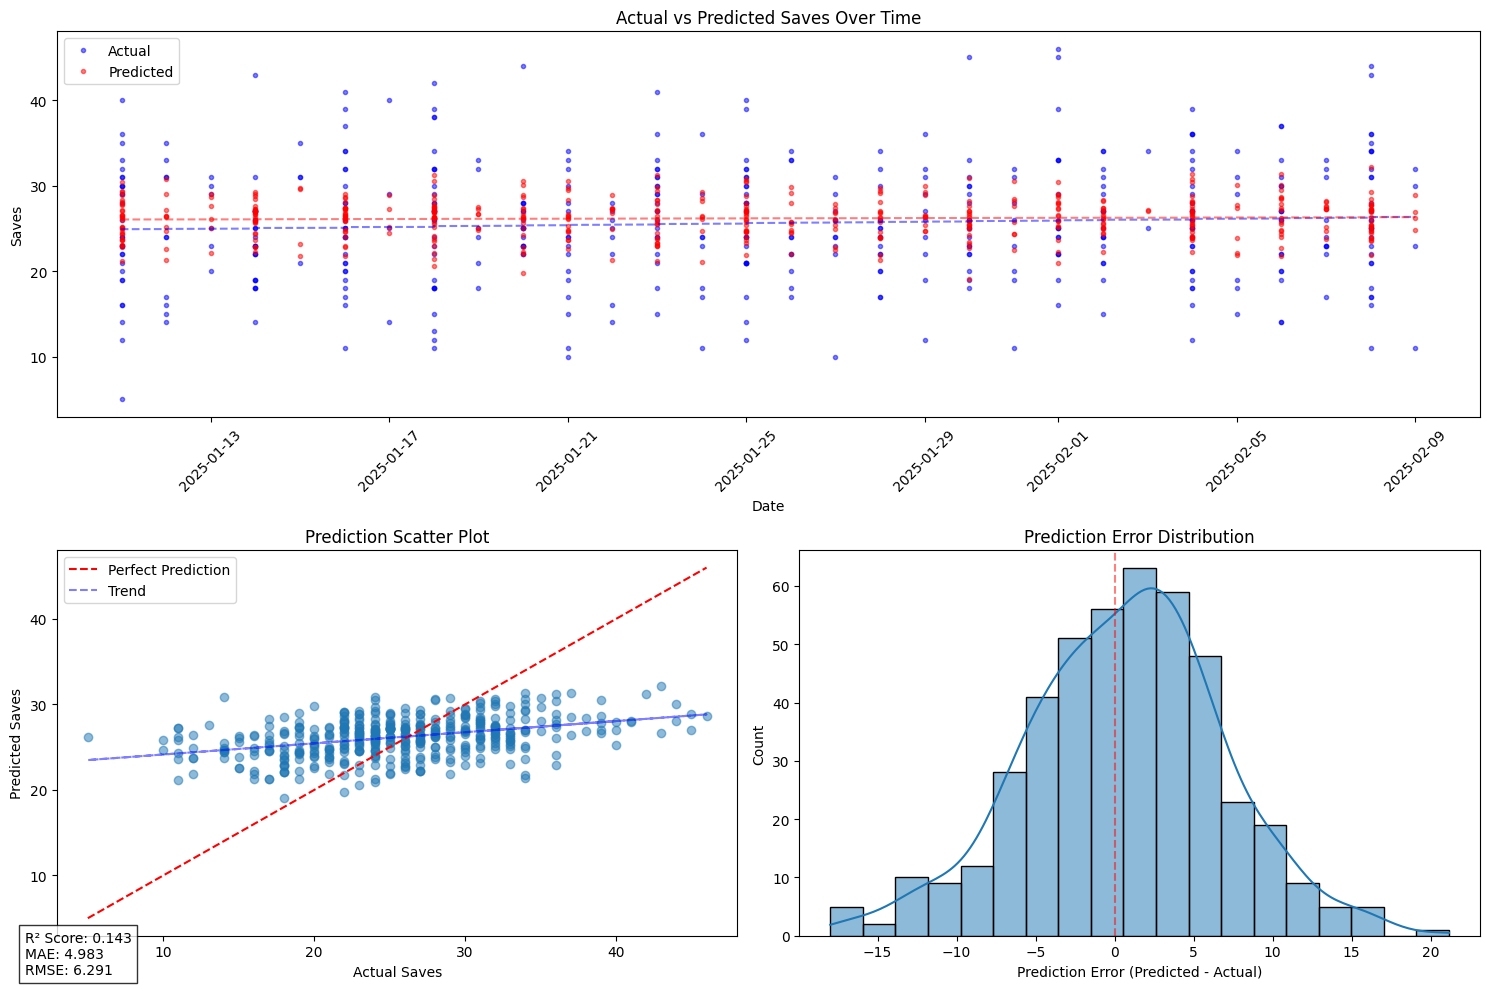


Error Statistics:
Mean Error: 0.593
Error Std Dev: 6.270
Error Range: [-17.990, 21.170]


In [15]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

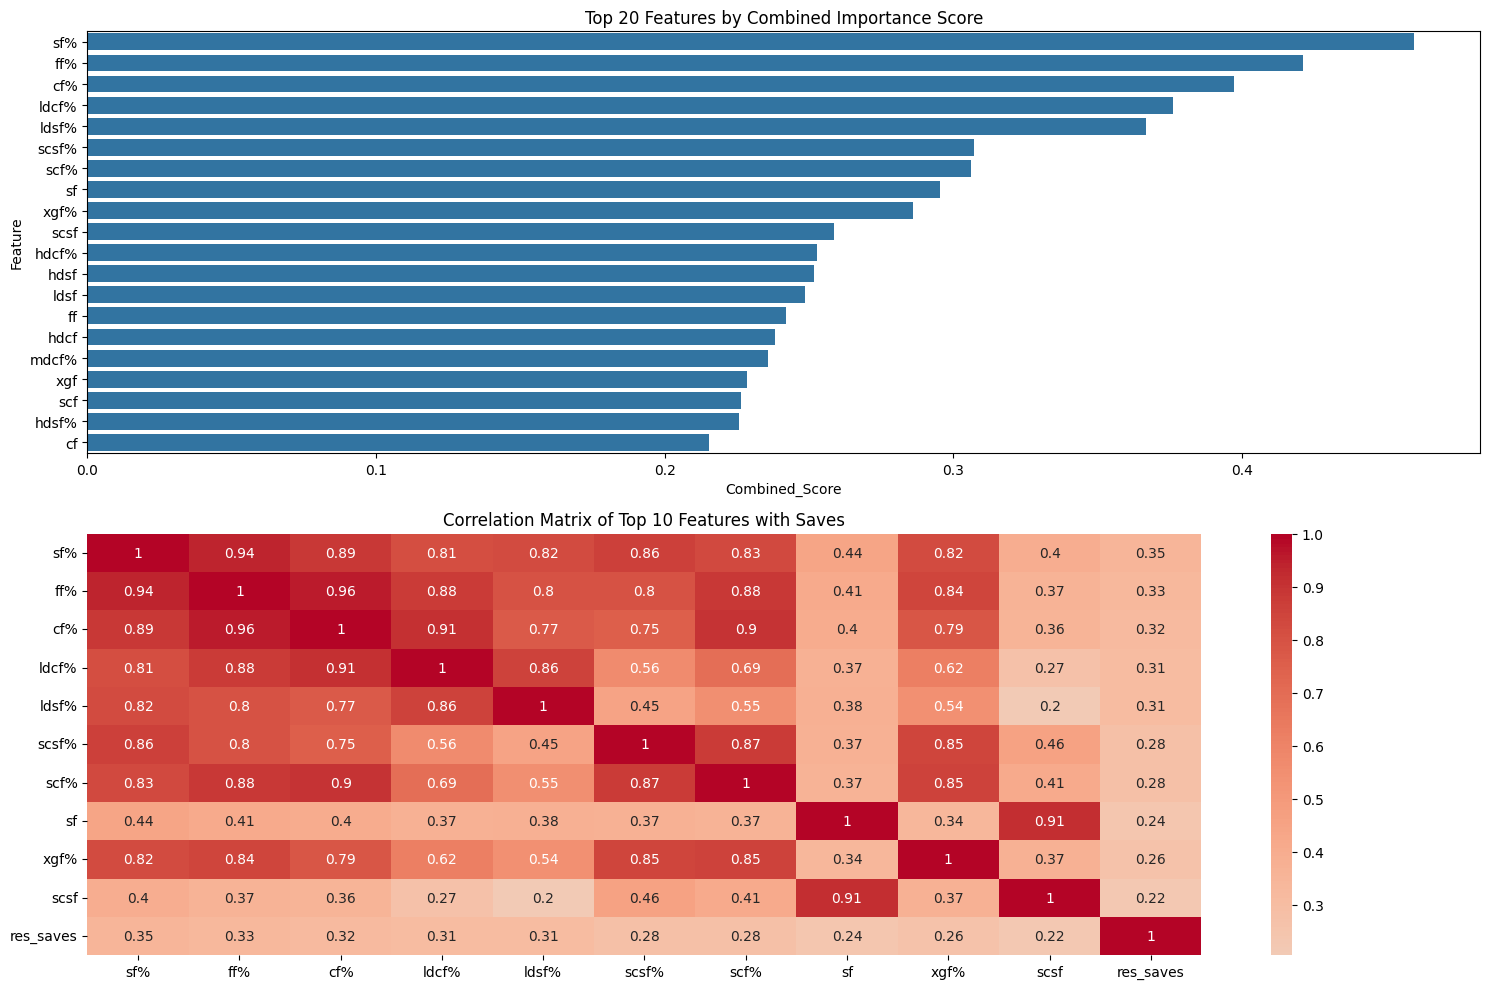


Top 20 Most Important Features for Predicting Saves:
   Feature  Combined_Score  Correlation  PCA_Importance  F_Score_Norm
9      sf%        0.459474     0.345414        0.033006      1.000000
6      ff%        0.421034     0.329622        0.033723      0.899759
3      cf%        0.397342     0.320371        0.027390      0.844265
51   ldcf%        0.376082     0.312016        0.020106      0.796122
54   ldsf%        0.366880     0.307838        0.020074      0.772727
21   scsf%        0.307218     0.276071        0.036588      0.608995
18    scf%        0.306021     0.276271        0.031844      0.609948
7       sf        0.295402     0.241274        0.188678      0.456256
15    xgf%        0.285910     0.264033        0.040545      0.553150
19    scsf        0.258513     0.221049        0.175283      0.379207
29   hdcf%        0.252866     0.246740        0.033340      0.478519
30    hdsf        0.251851     0.222338        0.149344      0.383871
52    ldsf        0.248700     0.218

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_features_for_saves_prediction(df):
    # Remove columns we don't want to consider as features
    exclude_cols = [
        'game_date', 'game_id', 'team', 'goalie_name', 'goalie_team', 'goalie_id', 
        'res_decision', 'res_saves', 'res_shots_against', 'res_save_pct', 'res_goals_against'
    ]
    
    # Convert boolean columns to int
    df['home'] = df['home'].astype(int)
    df['b2b'] = df['b2b'].astype(int)
    df['opp_b2b'] = df['opp_b2b'].astype(int)
    
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Create feature matrix and target vector
    X = df[feature_cols].copy()
    y = df['res_saves']
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # 2. Direct correlation with target
    correlations = []
    for col in feature_cols:
        corr = df[col].corr(y)
        correlations.append((col, abs(corr)))
    
    correlation_df = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
    correlation_df = correlation_df.sort_values('Correlation', ascending=False)
    
    # 3. Feature selection using f_regression
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X_scaled, y)
    f_scores = selector.scores_
    
    # Combine all feature importance metrics
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'PCA_Importance': np.abs(pca.components_[0]),
        'Correlation': [abs(df[col].corr(y)) for col in feature_cols],
        'F_Score': f_scores
    })
    
    # Normalize F-scores
    feature_importance_df['F_Score_Norm'] = feature_importance_df['F_Score'] / feature_importance_df['F_Score'].max()
    
    # Calculate combined importance score
    feature_importance_df['Combined_Score'] = (
        feature_importance_df['PCA_Importance'] + 
        feature_importance_df['Correlation'] + 
        feature_importance_df['F_Score_Norm']
    ) / 3
    
    feature_importance_df = feature_importance_df.sort_values('Combined_Score', ascending=False)
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Top 20 Features by Combined Score
    plt.subplot(2, 1, 1)
    sns.barplot(data=feature_importance_df.head(20), 
                x='Combined_Score', y='Feature')
    plt.title('Top 20 Features by Combined Importance Score')
    
    # Plot 2: Correlation Matrix of Top Features with Target
    plt.subplot(2, 1, 2)
    top_features = feature_importance_df.head(10)['Feature'].tolist() + ['res_saves']
    correlation_matrix = df[top_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Top 10 Features with Saves')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\nTop 20 Most Important Features for Predicting Saves:")
    print(feature_importance_df[['Feature', 'Combined_Score', 'Correlation', 'PCA_Importance', 'F_Score_Norm']].head(20))
    
    # Group features by type
    feature_groups = {
        'Goalie Performance': [col for col in feature_cols if col.startswith('g_')],
        'Team Stats': ['cf%', 'ff%', 'sf%', 'gf%', 'xgf%', 'scf%', 'hdcf%'],
        'Game Context': ['home', 'b2b', 'opp_b2b'],
        'Shot Quality': ['hdsv%', 'mdsv%', 'ldsv%']
    }
    
    print("\nAverage Importance by Feature Group:")
    for group, features in feature_groups.items():
        group_importance = feature_importance_df[
            feature_importance_df['Feature'].isin(features)
        ]['Combined_Score'].mean()
        print(f"{group}: {group_importance:.4f}")
    
    return feature_importance_df

# Run the analysis
feature_importance_df = analyze_features_for_saves_prediction(processed_df)

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit the grid search
print("Starting grid search...")
grid_search.fit(X_scaled, y)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\nTop 5 parameter combinations:")
top_5_params = cv_results[['params', 'mean_test_score', 'std_test_score']].head()
top_5_params['rmse'] = np.sqrt(-top_5_params['mean_test_score'])
print(top_5_params)

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Train final model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_scaled, y)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance from best model:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

Starting grid search...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

KeyboardInterrupt: 


Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_la

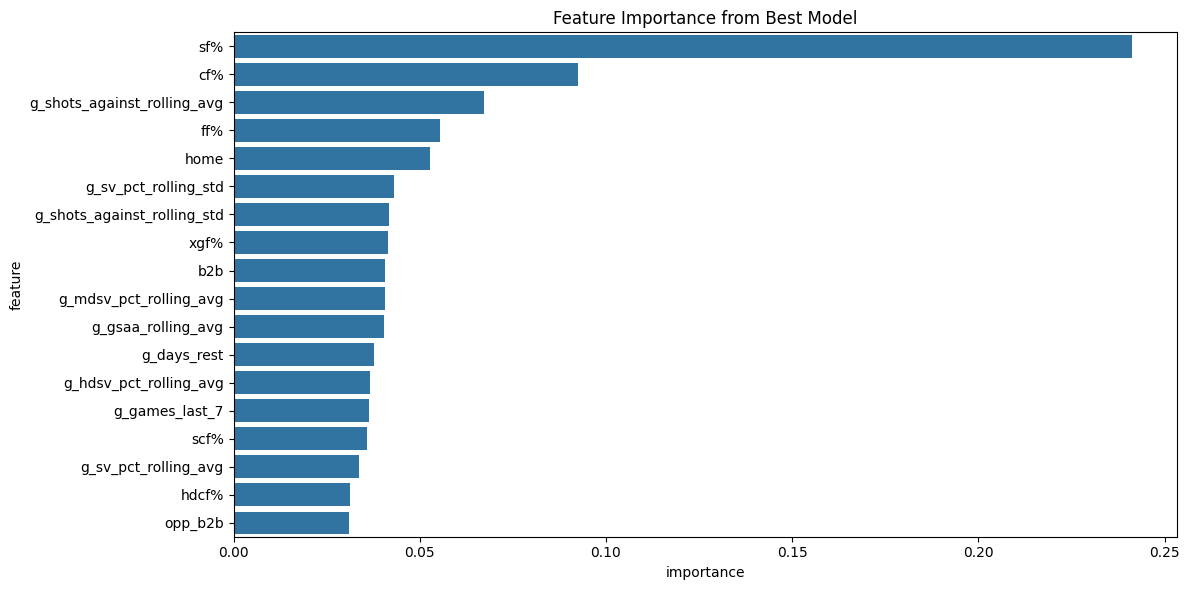

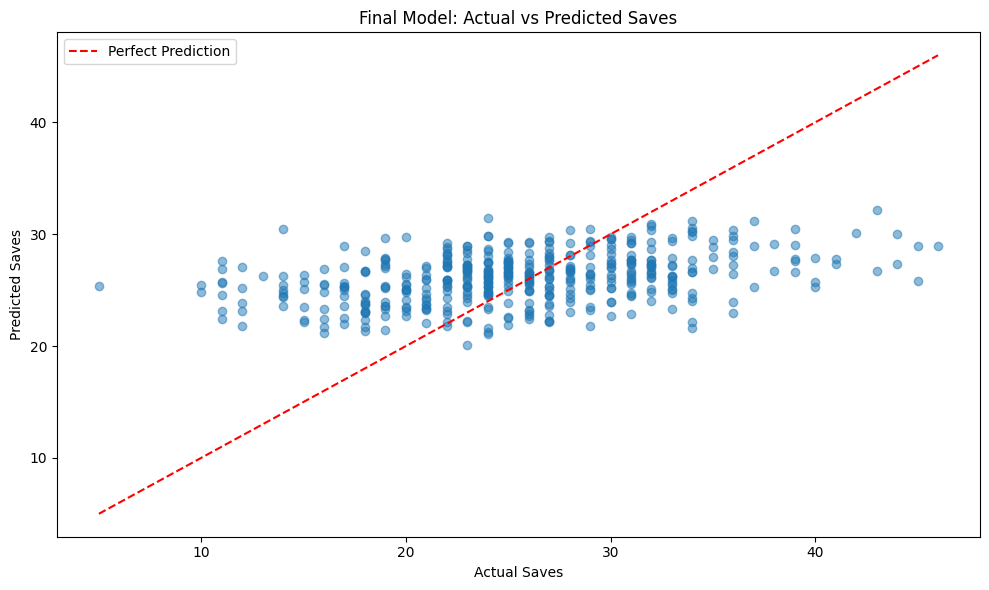

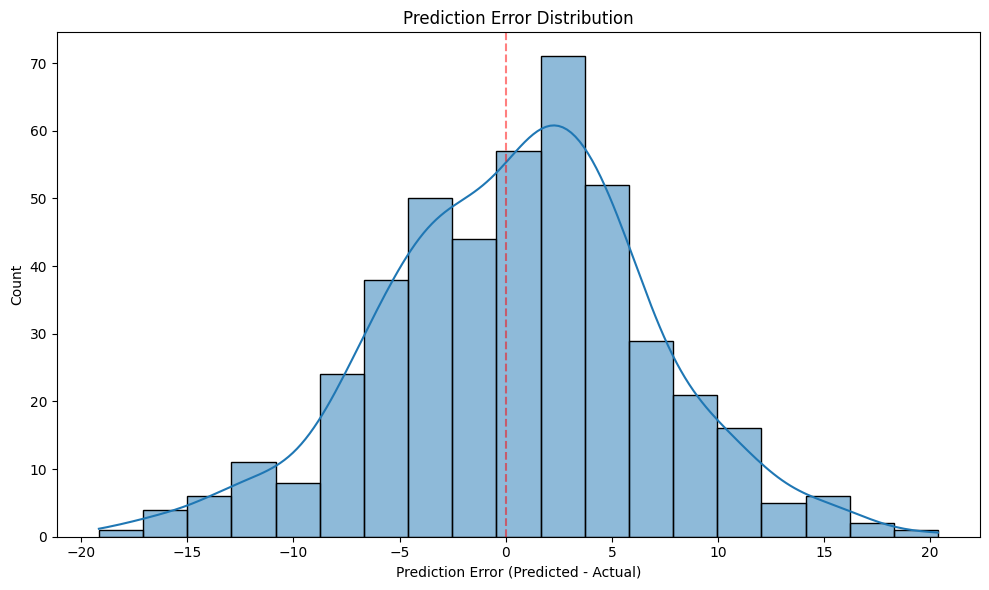


Total execution time: 2.96 seconds


In [19]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 4980 samples
Test set size: 446 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.1574
Explained Variance: 0.1613
Mean Absolute Error: 4.9217 saves
Median Absolute Error: 4.0226 saves
Root Mean Squared Error: 6.2384 saves
Maximum Error: 20.8604 saves

----- Error Distribution -----
Mean Error: 0.4262 saves
Error Standard Deviation: 6.2238
Error Skewness: -0.1136
Error Kurtosis: 0.2785
Normality Test p-value: 0.2788

----- Error Percentiles -----
Min Error: -18.0731 saves
25th Percentile: -3.6539 saves
Median Error: 0.7041 saves
75th Percentile: 4.3933 saves
Max Error: 20.8604 saves
Interquartile Range: 8.0471 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 11.66%
Predictions within ±2 saves: 23.32%
Predictions within ±3 saves: 37.67%
Predictions within ±5 saves: 61.88%


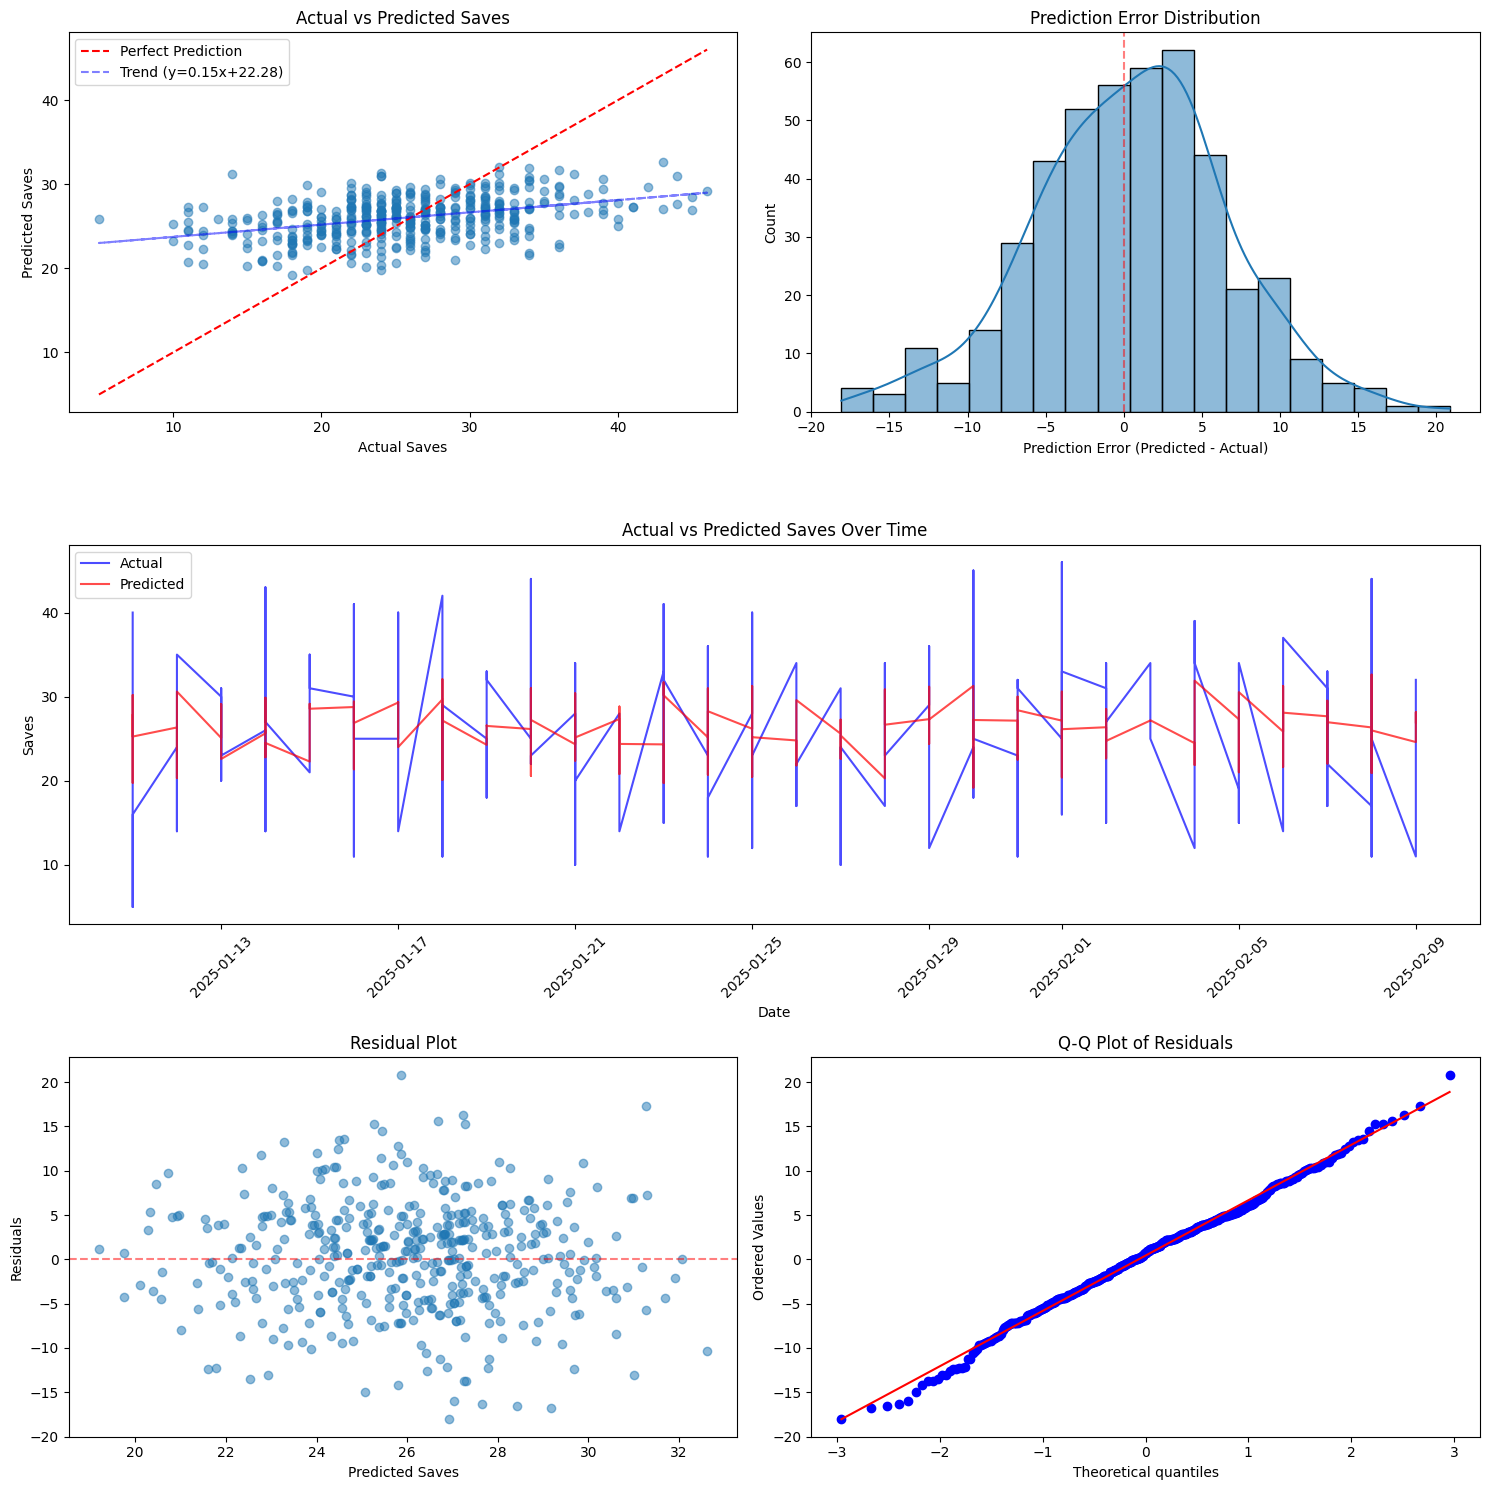

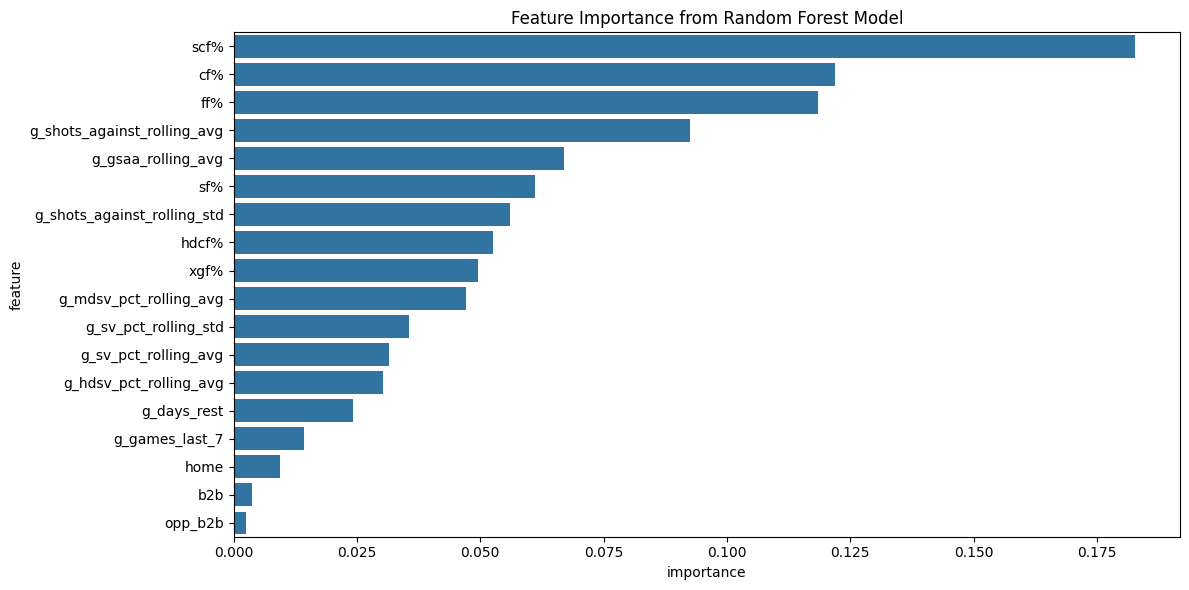


Total execution time: 6.60 seconds


In [20]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
    'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
    'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
    'g_games_last_7', 'g_days_rest',
    'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_saves']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_saves']
y_test = processed_df[test_mask]['res_saves']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

In [ ]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define a custom dataset class for PyTorch
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define an extremely simple neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # Ultra-simple architecture - just two layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),  # Smaller hidden layer
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with minimal computation
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=128, epochs=100, learning_rate=0.01):
    """
    Ultra-fast training function with minimal computation
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    
    print(f"Training ultra-fast neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run a minimal neural network evaluation
def run_minimal_goalie_nn():
    """
    Run an ultra-fast version of the neural network model
    """
    # Define features (using the comprehensive set that performed well)
    features = [
        'home', 'b2b', 'opp_b2b',
        'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
        'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
        'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
        'g_games_last_7', 'g_days_rest',
        'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
    ]

    # Prepare the data
    X = processed_df[features].copy()
    y = processed_df['res_saves']

    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_saves']
    y_test = processed_df[test_mask]['res_saves']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using only {len(features)} features for ultra-fast training")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the neural network with minimal settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=256,  # Very large batch size
        epochs=10,       # Minimal epochs
        learning_rate=0.01
    )
    
    # Plot predictions (simplified)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return model, scaler, metrics

# Run the ultra-fast neural network model
nn_model, nn_scaler, nn_metrics = run_minimal_goalie_nn()

Training set size: 4980 samples
Test set size: 446 samples
Using only 18 features for ultra-fast training


In [4]:
def predict_next_game(goalie_history, model, scaler, window_size=10):
    """Predict save percentage for next game"""
    X, _ = prepare_features(goalie_history, window_size)
    X_latest = X.iloc[[-1]]  # Get most recent game's features
    X_scaled = scaler.transform(X_latest)
    
    predicted_sv = model.predict(X_scaled)[0]
    return predicted_sv

def calculate_performance_scalar(predicted_sv, league_avg_sv=0.910):
    """Convert predicted save percentage to performance scalar"""
    sv_diff = predicted_sv - league_avg_sv
    return 1 - sv_diff

In [ ]:
# Now let's evaluate the model
processed_data = prepare_game_data(goalie_stats)
model, scaler, metrics = train_model(processed_data)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f}")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f}")

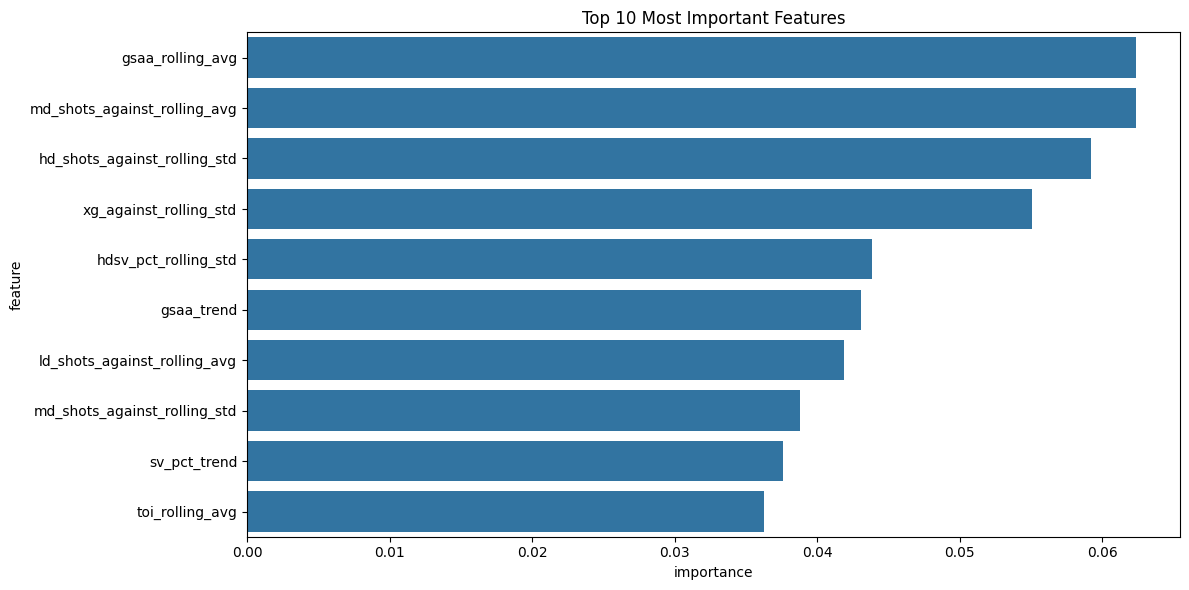

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    'feature': list(metrics['feature_importance'].keys()),
    'importance': list(metrics['feature_importance'].values())
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

Original data length: 21
Predictions length: 21
X_scaled shape: (21, 28)


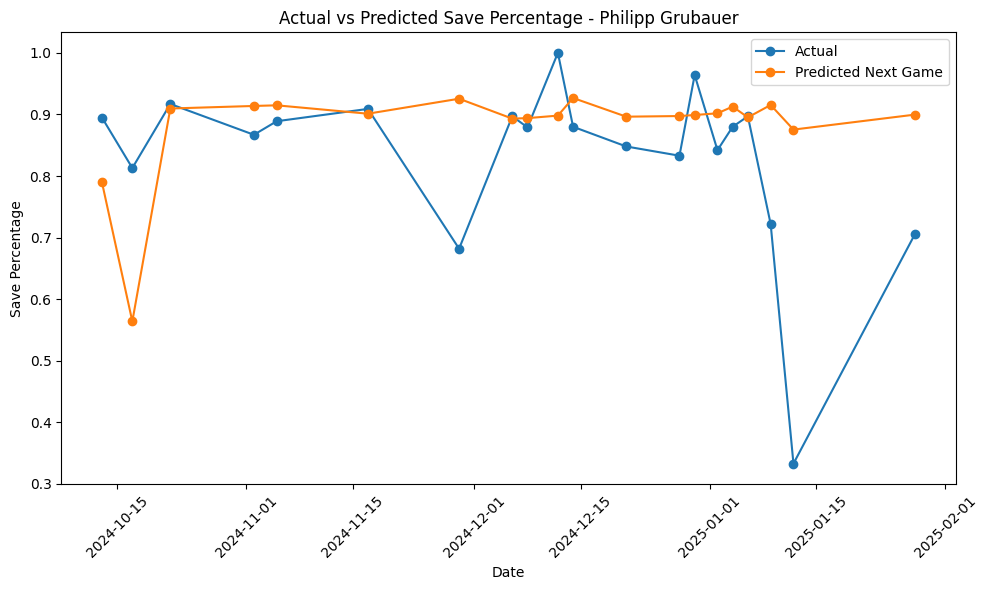


Predicted save percentage for Philipp Grubauer's next game: 0.837


In [ ]:
# Plot actual vs predicted values for a specific goalie
goalie_name = 'Philipp Grubauer'
goalie_data = processed_data[processed_data['player'] == goalie_name].copy()  # Make a copy
X, processed_df = prepare_features(goalie_data)
X_scaled = scaler.transform(X)
predictions = model.predict(X_scaled)

# Print dimensions to debug
print(f"Original data length: {len(goalie_data)}")
print(f"Predictions length: {len(predictions)}")
print(f"X_scaled shape: {X_scaled.shape}")

# Create the plot with aligned data
plt.figure(figsize=(10, 6))
# Use the same date range for both actual and predicted values
dates = goalie_data['date'].iloc[:-1]  # Remove last date
actual_values = goalie_data['sv_pct'].iloc[:-1]  # Remove last actual value

plt.plot(dates, actual_values, label='Actual', marker='o')
plt.plot(dates, predictions[:-1], label='Predicted Next Game', marker='o')
plt.title(f'Actual vs Predicted Save Percentage - {goalie_name}')
plt.xlabel('Date')
plt.ylabel('Save Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the prediction for the next game
print(f"\nPredicted save percentage for {goalie_name}'s next game: {predictions[-1]:.3f}")

In [46]:
performance_scalar

1.0187401996962557

In [47]:
g

NameError: name 'g' is not defined